# Xenomatix Internship


## Faster R-CNN

In [1]:
from torchvision import transforms as T 
from torchvision import utils as utils
from torchvision.utils import save_image
import cv2
from PIL import Image
from matplotlib import pyplot as plt

### Pre-trained model

In [ ]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [3]:
# This is needed to display the images.
%matplotlib inline

## Available categories in model

In [7]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

#Making selection of only 7 categories for our model
object_class = {'person':1,'bicycle':2,'motorcycle':3,'car':4,'train':5,'truck':6,'bus':7}
# person=1, bycycle=2, car = 3, motorcycle=4, train=5, truck = 6, bus=7 
category_list = ['person','bicycle','motorcycle','car','train','truck','bus']
# object_class["person"]

### 1. Predicting score | 2. Classification | 3. Bounding box dimensions

In [5]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = model([img]) # Pass the image to the model
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score        
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy()) ] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())        
    
    #To avoid list index out of range error when list is empty aka detection score is less than 0.8
    list_score = [pred_score.index(x) for x in pred_score if x > threshold]    
    if not list_score:
        return [],[],[]
        
    pred_t = list_score[-1] # Get list of index with score greater than threshold.     
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_scores = pred_score[:pred_t+1]

    #filtering only person,bicycle,motorcycle,car,truck bus for the project
    classes = [object_class[i] for i in pred_class if str(i) in category_list]
    boxes = [pred_boxes[pos] for pos,i in enumerate(pred_class) if str(i) in category_list]    
    
    return boxes, classes, pred_scores


### To display object detection for an individual image

In [6]:
def object_detection_api(img_path, threshold=0.5, rect_th=2, text_size=1, text_th=2):
    boxes, pred_cls, score = get_prediction(img_path, threshold) # Get predictions    
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(boxes)):
#         print(boxes[i],pred_cls[i])
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(248,248,255), thickness=rect_th) # Draw Rectangle with the coordinates
        text = str(pred_cls[i]) + '(' + str(round(score[i],2))+')'
        cv2.putText(img,text, boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (248,248,255),thickness=text_th) # Write the prediction class
    plt.figure(figsize=(20,30)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()


## To do the object detection, saving the image and dimension text on local system

In [10]:
# Object detection without output image

def object_detection_and_saving(img_path, save_path, labels_path, threshold=0.5, rect_th=2, text_size=1, text_th=2):
    boxes, pred_cls, score = get_prediction(img_path, threshold) # Get predictions    
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0,0,255), thickness=rect_th) # Draw Rectangle with the coordinates
        text = str(pred_cls[i]) + '(' + str(round(score[i],2))+')'
        cv2.putText(img,text, boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class

#     Saving the image
    cv2.imwrite(save_path,img)        
    
    #Saving the dimensions text file
    f= open(labels_path,"w+")
    for pos,val in enumerate(boxes):        
        f.write("%.4f,%.4f,%.4f,%.4f,%d,%.2f\r" % (val[0][0],val[0][1],val[1][0],val[1][1],pred_cls[pos],score[pos]*100))
    
    f.close()           


### For *testing* a single image

In [68]:
#Test run
#Detected by Faster R-CNN
object_detection_and_saving('C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/VisualImages/xl_visual_session0002_00000708.vis.png','C:/Users/nisha/MACS/Internship/Data/test.png', 'C:/Users/nisha/MACS/Internship/Data/test.txt',threshold=0.70)


### Final Run for all the images

In [11]:
#Final
#Run only once

from os import listdir
from os.path import isfile, join
import numpy
import time

#Tracing the time
start = time.time()

input_path = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/VisualImages/'
labels_path = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/label_FasterRCNN/'
detection_path = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/Detection_FasterRCNN/'
txt='.txt'

onlyfiles = [ f for f in listdir(input_path) if isfile(join(input_path,f))]
# images = numpy.empty(len(onlyfiles), dtype=object)
for image_id in onlyfiles:
    image_name = image_id.split(".")
    input_image = input_path+image_id
    detected_image = detection_path+image_id
    labels_text = labels_path+image_name[0]+txt
    object_detection_and_saving(input_image, detected_image, labels_text, threshold=0.80)    

#Time taken
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

08:44:52.72


## Converting the XML files to txt files
### Ground truth text

In [4]:
import libs
import pascal_voc_io

In [8]:
from os import listdir
from os.path import isfile, join
import numpy

xml_count =0

annotations_xml = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/Annotation/'
annotation_txt = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/groundtruth_txt/'
txt = '.txt'

for xml_id in listdir(annotations_xml):        
    xml_count+=1
    xml_name = xml_id.split(".")
    labels_text = annotation_txt+xml_name[0]+txt   
    xml_path = annotations_xml+xml_id    
    pascal_voc_reader = pascal_voc_io.PascalVocReader(xml_path)    
    shapes = pascal_voc_reader.getShapes()
    
    #Saving the dimensions text file
    f= open(labels_text,"w+")
    for val in shapes:                    
        f.write("%.d,%.d,%.d,%.d,%d\r" % (val[1][0][0],val[1][0][1],val[1][2][0],val[1][2][1],object_class[val[0]]))    
    f.close()    


## Converting txt to XML files

In [6]:
import os
os.chdir('C:/Users/nisha/MACS/Internship/Data/labelImg/libs/')

In [7]:
import libs
import pascal_voc_io

In [9]:
import glob as glob
import numpy as np
import cv2
from tqdm import tqdm
import sys

# root_dir = r'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train'
# labels_path = r'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/label_FasterRCNN'
# visual_path = r'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/VisualImages'


root_dir = r'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val'
labels_path = os.path.join(root_dir, 'detection_txt')
visual_path = os.path.join(root_dir, 'detection')

category_list = ['__background__','person','bicycle','motorcycle','car','train','truck','bus']

# search all XL annotation files (.txt files) in the folder labels_path
annotation_files = sorted(glob.glob(os.path.join(labels_path, 'xl_visual*.txt')))

nr_annotation_files = len(annotation_files)

print('Found {} annotation files'.format(nr_annotation_files))

for annotation_file in tqdm(annotation_files):
    # get the basename of the input
    basename = os.path.basename(annotation_file)
    basename = basename.replace('xl_visual','')
    basename = basename.replace('.txt','')
    
    # read the object list
    object_list = np.loadtxt(annotation_file, dtype=np.float, comments='#', delimiter=',')

    # read the visual image
    # FIXME: we should remove .vis from all the filenames
    visual_image          = None
    visual_image_filename = ''
    image_path            = ''
    with_vis              = ''

    visual_image_filename = 'xl_visual' + basename + '.png'
    image_path = os.path.join(visual_path,'xl_visual' + basename + '.vis.png')
#     print(image_path)
    visual_image = cv2.imread(image_path)    
#     with_vis = ''
    
    
    image_shape = None
    if visual_image is not None:
        image_shape = [visual_image.shape[0], visual_image.shape[1], 1] # height, width, channel        
    else:                
        continue

    
    # if there are objects in the object list
    if object_list.size:        
        # create a pascal voc dataset writer
        writer = pascal_voc_io.PascalVocWriter(visual_path, visual_image_filename, image_shape, databaseSrc='XL_Dataset_INT_v2', localImgPath=image_path)

        # deal with the special case
        # when there is only one object in the list
        # the object list shape is (5,) instead of (N,5) where N is the number of objects
        # @Nishant, you should make sure that the shape of object list is always (N,5)
        if len(object_list.shape) == 1:
            x_min      = object_list[0]
            y_min      = object_list[1]
            x_max      = object_list[2]
            y_max      = object_list[3]
            class_id   = int(object_list[4])
            class_name = category_list[class_id]

            writer.addBndBox(x_min, y_min, x_max, y_max, class_name, 0)

        else:
            nr_objects = object_list.shape[0]

            for i in range(nr_objects):
                x_min      = object_list[i][0]
                y_min      = object_list[i][1]
                x_max      = object_list[i][2]
                y_max      = object_list[i][3]
                class_id   = int(object_list[i][4])
                class_name = category_list[class_id]

                writer.addBndBox(x_min, y_min, x_max, y_max, class_name, 0)

        # output the xml file
        # the xml file should have exactly the same name compared to the visual image file (including .vis part)
        writer.save(targetFile= visual_path + '/' + 'xl_visual' + basename + with_vis + '.vis.xml')


  0%|▏                                                                                | 4/1412 [00:00<00:40, 34.81it/s]

Found 1412 annotation files
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000026.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000051.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000064.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000068.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000080.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000088.vis.png


  1%|▋                                                                               | 12/1412 [00:00<00:41, 34.14it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000100.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000104.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000108.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000120.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000144.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000152.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000160.vis.png


  1%|▊                                                                               | 15/1412 [00:00<00:44, 31.42it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000180.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000261.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000321.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000326.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000335.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000353.vis.png


  2%|█▎                                                                              | 23/1412 [00:00<00:46, 29.76it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000357.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000403.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000408.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000410.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000437.vis.png


  2%|█▋                                                                              | 30/1412 [00:00<00:49, 28.18it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000461.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000499.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000507.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000510.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000525.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000563.vis.png


  2%|█▉                                                                              | 34/1412 [00:01<00:46, 29.36it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000566.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000572.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000580.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000587.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000590.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000615.vis.png


  3%|██▎                                                                             | 41/1412 [00:01<00:45, 30.46it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000619.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000696.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000699.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000722.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000733.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000743.vis.png


  3%|██▌                                                                             | 45/1412 [00:01<00:45, 29.82it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000749.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000760.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000792.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000809.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000817.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000842.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000865.vis.png


  4%|███                                                                             | 53/1412 [00:01<00:45, 29.62it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000873.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000912.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000968.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000976.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000983.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00000992.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001001.vis.png

  4%|███▌                                                                            | 62/1412 [00:01<00:39, 34.16it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001018.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001026.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001070.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001174.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001220.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001236.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001249.vis.png


  5%|████                                                                            | 71/1412 [00:02<00:38, 35.29it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001258.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001286.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001292.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001302.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001309.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001347.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001388.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001409.vis.png


  5%|████▏                                                                           | 75/1412 [00:02<00:37, 35.66it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001421.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001438.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001487.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001544.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001589.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001598.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001603.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001612.vis.png
C:/Users/nisha/M

  6%|████▊                                                                           | 85/1412 [00:02<00:34, 38.92it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001707.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001713.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001743.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001802.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001806.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001810.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001815.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001851.vis.png
C:/Users/nisha/M

  7%|█████▎                                                                          | 93/1412 [00:02<00:38, 34.61it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001864.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001884.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001950.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001955.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001973.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001985.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001988.vis.png


  7%|█████▋                                                                         | 102/1412 [00:03<00:35, 36.53it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001992.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00001996.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002005.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002025.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002029.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002033.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002037.vis.png


  8%|█████▉                                                                         | 106/1412 [00:03<00:42, 31.06it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002057.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002092.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002105.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002123.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002132.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002162.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002184.vis.png


  8%|██████▍                                                                        | 115/1412 [00:03<00:36, 35.17it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002215.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002251.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002272.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002286.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002295.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002304.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002348.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002352.vis.png


  8%|██████▋                                                                        | 119/1412 [00:03<00:39, 32.60it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002375.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002379.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002393.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002406.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002429.vis.png


  9%|███████                                                                        | 127/1412 [00:03<00:45, 28.22it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002433.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002469.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002474.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002505.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002514.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002519.vis.png


  9%|███████▍                                                                       | 133/1412 [00:04<00:44, 28.43it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002564.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002617.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002626.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002639.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002644.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002671.vis.png


 10%|███████▊                                                                       | 139/1412 [00:04<00:48, 26.43it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002680.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002711.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002756.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002828.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002846.vis.png


 10%|████████                                                                       | 145/1412 [00:04<00:50, 24.98it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002967.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00002981.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00003003.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00003009.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00003063.vis.png


 10%|████████▎                                                                      | 148/1412 [00:04<00:50, 25.03it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00003069.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00003075.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00003085.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0000_00003196.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000010.vis.png


 11%|████████▌                                                                      | 154/1412 [00:04<00:48, 26.03it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000039.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000051.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000089.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000092.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000112.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000129.vis.png


 11%|█████████                                                                      | 161/1412 [00:05<00:46, 27.09it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000145.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000180.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000280.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000284.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000305.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000308.vis.png


 12%|█████████▏                                                                     | 164/1412 [00:05<00:49, 25.36it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000319.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000333.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000340.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000354.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000357.vis.png


 12%|█████████▌                                                                     | 170/1412 [00:05<00:54, 22.74it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000389.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000403.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000455.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000473.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000501.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000511.vis.png

 12%|█████████▋                                                                     | 174/1412 [00:05<00:50, 24.36it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000522.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000532.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000565.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000598.vis.png


 13%|██████████▏                                                                    | 181/1412 [00:06<00:47, 25.67it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000678.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000735.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000753.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000757.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000761.vis.png


 13%|██████████▎                                                                    | 184/1412 [00:06<00:50, 24.26it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000797.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000815.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000827.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000834.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000844.vis.png


 14%|██████████▋                                                                    | 191/1412 [00:06<00:46, 26.08it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000851.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000865.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000940.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000951.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000954.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000957.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000963.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00000990.vis.png


 14%|███████████▏                                                                   | 199/1412 [00:06<00:45, 26.71it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00001011.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00001023.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00001032.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00001038.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0001_00001062.vis.png


 15%|███████████▍                                                                   | 205/1412 [00:06<00:44, 27.12it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000006.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000014.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000034.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000038.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000042.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000046.vis.png

 15%|███████████▋                                                                   | 208/1412 [00:07<00:43, 27.81it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000075.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000161.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000229.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000248.vis.png


 15%|███████████▉                                                                   | 214/1412 [00:07<00:48, 24.87it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000320.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000324.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000341.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000368.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000377.vis.png


 15%|████████████▏                                                                  | 217/1412 [00:07<00:50, 23.78it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000387.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000406.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000442.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000447.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000456.vis.png

 16%|████████████▎                                                                  | 220/1412 [00:07<00:57, 20.81it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000475.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000513.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000517.vis.png


 16%|████████████▋                                                                  | 226/1412 [00:07<00:53, 22.25it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000535.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000558.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000582.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000604.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000627.vis.png


 16%|████████████▉                                                                  | 232/1412 [00:08<00:50, 23.16it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000662.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000680.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000702.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000708.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000720.vis.png


 17%|█████████████▏                                                                 | 235/1412 [00:08<00:48, 24.37it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000731.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000737.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000773.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000782.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000814.vis.png


 17%|█████████████▍                                                                 | 241/1412 [00:08<00:55, 21.11it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000864.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000874.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000893.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000897.vis.png


 17%|█████████████▋                                                                 | 244/1412 [00:08<00:56, 20.69it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000920.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000930.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000934.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000948.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000952.vis.png


 18%|██████████████                                                                 | 251/1412 [00:09<00:50, 22.78it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000966.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00000988.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001011.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001020.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001033.vis.png


 18%|██████████████▏                                                                | 254/1412 [00:09<00:49, 23.51it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001096.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001101.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001119.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001137.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001141.vis.png


 18%|██████████████▌                                                                | 260/1412 [00:09<00:55, 20.87it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001159.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001182.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001209.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001263.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001267.vis.png


 19%|██████████████▋                                                                | 263/1412 [00:09<00:54, 21.05it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001276.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001290.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001303.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001348.vis.png


 19%|███████████████                                                                | 269/1412 [00:09<00:51, 22.41it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001353.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001366.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001407.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001452.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001479.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001497.vis.png


 20%|███████████████▍                                                               | 277/1412 [00:10<00:41, 27.23it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001535.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001558.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001563.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001585.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001599.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001608.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001612.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001630.vis.png


 20%|███████████████▋                                                               | 281/1412 [00:10<00:40, 27.71it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001635.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001648.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001662.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001689.vis.png


 20%|████████████████                                                               | 287/1412 [00:10<00:45, 24.74it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001702.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001716.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001725.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001780.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001784.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001793.vis.png

 21%|████████████████▍                                                              | 293/1412 [00:10<00:44, 25.07it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001861.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001870.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001874.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001893.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001921.vis.png


 21%|████████████████▋                                                              | 299/1412 [00:10<00:43, 25.40it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001930.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001935.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001939.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001944.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00001969.vis.png


 21%|████████████████▉                                                              | 302/1412 [00:11<00:51, 21.63it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002001.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002023.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002055.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002059.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002095.vis.png


 22%|█████████████████▎                                                             | 310/1412 [00:11<00:45, 24.40it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002117.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002128.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002155.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002165.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002179.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002207.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002225.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002251.vis.png
C:/Users/nisha/M

 23%|█████████████████▉                                                             | 320/1412 [00:11<00:34, 31.24it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002363.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002366.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002389.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002399.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002424.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002427.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002441.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002459.vis.png


 23%|██████████████████▏                                                            | 324/1412 [00:11<00:38, 28.57it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002468.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002562.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002593.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002607.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002620.vis.png


 23%|██████████████████▌                                                            | 331/1412 [00:12<00:42, 25.27it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002665.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002704.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002740.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002824.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002874.vis.png

 24%|██████████████████▋                                                            | 334/1412 [00:12<00:45, 23.63it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002887.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002896.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002905.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002950.vis.png


 24%|███████████████████                                                            | 340/1412 [00:12<00:46, 22.98it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002956.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002960.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002978.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002983.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00002988.vis.png


 24%|███████████████████▏                                                           | 343/1412 [00:12<00:46, 23.05it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003006.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003015.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003042.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003060.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003065.vis.png


 25%|███████████████████▌                                                           | 349/1412 [00:12<00:45, 23.23it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003069.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003078.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003087.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003105.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003110.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003137.vis.png


 25%|███████████████████▉                                                           | 356/1412 [00:13<00:42, 24.97it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003164.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003191.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003195.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003200.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003213.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003222.vis.png


 26%|████████████████████▎                                                          | 363/1412 [00:13<00:37, 27.68it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003231.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003254.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003281.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003313.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003385.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003439.vis.png


 26%|████████████████████▍                                                          | 366/1412 [00:13<00:41, 24.97it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003444.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003453.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003463.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003465.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003516.vis.png


 26%|████████████████████▋                                                          | 369/1412 [00:13<00:43, 23.70it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003528.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003537.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003546.vis.png


 27%|████████████████████▉                                                          | 375/1412 [00:14<00:48, 21.50it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003569.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003572.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003581.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003589.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003592.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003621.vis.png


 27%|█████████████████████▎                                                         | 381/1412 [00:14<00:50, 20.53it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003656.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003665.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003686.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003715.vis.png


 27%|█████████████████████▍                                                         | 384/1412 [00:14<00:54, 18.93it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003721.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003727.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003732.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003756.vis.png


 27%|█████████████████████▋                                                         | 387/1412 [00:14<00:59, 17.19it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003759.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003786.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003789.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003792.vis.png


 28%|█████████████████████▉                                                         | 393/1412 [00:15<00:50, 19.99it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003811.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003821.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003830.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0002_00003833.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000006.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000026.vis.png


 28%|██████████████████████▎                                                        | 399/1412 [00:15<00:44, 22.78it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000030.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000088.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000102.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000107.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000117.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000173.vis.png


 29%|██████████████████████▋                                                        | 405/1412 [00:15<00:41, 24.17it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000208.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000213.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000228.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000238.vis.png


 29%|██████████████████████▊                                                        | 408/1412 [00:15<00:48, 20.66it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000248.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000258.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000268.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000331.vis.png


 29%|███████████████████████▏                                                       | 414/1412 [00:15<00:44, 22.66it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000335.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000359.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000373.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000387.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000400.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000417.vis.png


 30%|███████████████████████▍                                                       | 420/1412 [00:16<00:39, 24.95it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000431.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000434.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000458.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000467.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000479.vis.png


 30%|███████████████████████▋                                                       | 423/1412 [00:16<00:45, 21.66it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000512.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000519.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000526.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000568.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000575.vis.png


 30%|████████████████████████                                                       | 429/1412 [00:16<00:45, 21.53it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000622.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000628.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000635.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000642.vis.png


 31%|████████████████████████▏                                                      | 432/1412 [00:16<00:49, 20.00it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000663.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000684.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000764.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000810.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000828.vis.png


 31%|████████████████████████▌                                                      | 438/1412 [00:17<00:45, 21.62it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000841.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000886.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000891.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000902.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000966.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000976.vis.png


 32%|█████████████████████████                                                      | 447/1412 [00:17<00:33, 28.48it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00000995.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001014.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001020.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001078.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001123.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001127.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001151.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001213.vis.png


 32%|█████████████████████████▏                                                     | 451/1412 [00:17<00:32, 29.72it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001249.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001258.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001262.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001330.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001348.vis.png


 33%|█████████████████████████▋                                                     | 459/1412 [00:17<00:35, 27.15it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001358.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001361.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001371.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001413.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001436.vis.png


 33%|█████████████████████████▊                                                     | 462/1412 [00:17<00:34, 27.85it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001439.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001449.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001452.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001458.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001467.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001472.vis.png


 33%|██████████████████████████▏                                                    | 469/1412 [00:18<00:34, 27.44it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001489.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001491.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001496.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001498.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001517.vis.png


 33%|██████████████████████████▍                                                    | 472/1412 [00:18<00:44, 21.22it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001533.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001535.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001552.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001558.vis.png


 34%|██████████████████████████▋                                                    | 478/1412 [00:18<00:40, 22.98it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001615.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001650.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001678.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001707.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001727.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001731.vis.png


 34%|███████████████████████████                                                    | 484/1412 [00:18<00:40, 23.03it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001760.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001764.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001774.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001779.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001788.vis.png


 34%|███████████████████████████▏                                                   | 487/1412 [00:18<00:38, 23.77it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001792.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001811.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001828.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001846.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001868.vis.png


 35%|███████████████████████████▌                                                   | 493/1412 [00:19<00:40, 22.74it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001890.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001899.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001904.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001917.vis.png


 35%|███████████████████████████▊                                                   | 496/1412 [00:19<00:43, 21.25it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00001944.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002009.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002037.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002064.vis.png


 35%|███████████████████████████▉                                                   | 499/1412 [00:19<00:43, 20.75it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002079.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002097.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002121.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002147.vis.png


 36%|████████████████████████████▎                                                  | 506/1412 [00:19<00:40, 22.44it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002174.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002204.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002216.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002221.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002227.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002245.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002261.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002270.vis.png


 36%|████████████████████████████▊                                                  | 514/1412 [00:20<00:37, 24.23it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002308.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002315.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002380.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002389.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002412.vis.png


 37%|████████████████████████████▉                                                  | 517/1412 [00:20<00:36, 24.57it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002421.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002454.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002469.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002511.vis.png


 37%|█████████████████████████████▎                                                 | 523/1412 [00:20<00:36, 24.51it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002560.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002626.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002754.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002759.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002775.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002790.vis.png


 37%|█████████████████████████████▌                                                 | 529/1412 [00:20<00:37, 23.39it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002890.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002896.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002908.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002913.vis.png


 38%|█████████████████████████████▊                                                 | 533/1412 [00:20<00:33, 25.88it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002920.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002925.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002934.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00002973.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003001.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003006.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003015.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003046.vis.png


 38%|██████████████████████████████▎                                                | 541/1412 [00:20<00:29, 29.76it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003060.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003101.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003110.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003213.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003222.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003225.vis.png


 39%|██████████████████████████████▍                                                | 545/1412 [00:21<00:35, 24.24it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003238.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003254.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003266.vis.png


 39%|██████████████████████████████▋                                                | 548/1412 [00:21<00:39, 21.84it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003269.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003276.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003323.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003325.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003330.vis.png


 39%|██████████████████████████████▉                                                | 554/1412 [00:21<00:39, 21.74it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003338.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003354.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003383.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003402.vis.png


 40%|███████████████████████████████▍                                               | 563/1412 [00:21<00:32, 26.27it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003461.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003470.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003497.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003501.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003598.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003624.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003704.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003707.vis.png
C:/Users/nisha/M

 40%|███████████████████████████████▊                                               | 568/1412 [00:22<00:28, 29.92it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003783.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003792.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003865.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003883.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003902.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003906.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003930.vis.png


 41%|████████████████████████████████                                               | 572/1412 [00:22<00:28, 29.99it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00003969.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004010.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004028.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004037.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004071.vis.png


 41%|████████████████████████████████▍                                              | 579/1412 [00:22<00:37, 22.47it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004089.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004092.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004099.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004108.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004135.vis.png


 42%|████████████████████████████████▊                                              | 587/1412 [00:22<00:30, 27.25it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004140.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004144.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004180.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004200.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004215.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004265.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004302.vis.png


 42%|█████████████████████████████████                                              | 591/1412 [00:22<00:30, 27.31it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004315.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004334.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004338.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004344.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004347.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004350.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004375.vis.png


 42%|█████████████████████████████████▌                                             | 599/1412 [00:23<00:30, 26.86it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004387.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004427.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004498.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004507.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004542.vis.png


 43%|█████████████████████████████████▋                                             | 602/1412 [00:23<00:33, 24.09it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004562.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004599.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004631.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004640.vis.png


 43%|██████████████████████████████████                                             | 608/1412 [00:23<00:36, 21.75it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004655.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004669.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004744.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004763.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004771.vis.png

 43%|██████████████████████████████████▏                                            | 611/1412 [00:23<00:38, 20.88it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004784.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004820.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004827.vis.png


 43%|██████████████████████████████████▎                                            | 614/1412 [00:23<00:37, 21.12it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004848.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004852.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004897.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004901.vis.png


 44%|██████████████████████████████████▌                                            | 617/1412 [00:24<00:43, 18.36it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004911.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004922.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004929.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004936.vis.png


 44%|██████████████████████████████████▊                                            | 623/1412 [00:24<00:38, 20.24it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004955.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004967.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004973.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004981.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004983.vis.png


 45%|███████████████████████████████████▏                                           | 629/1412 [00:24<00:38, 20.29it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004986.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004988.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00004995.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005007.vis.png


 45%|███████████████████████████████████▎                                           | 632/1412 [00:24<00:36, 21.45it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005016.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005022.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005049.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005063.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005084.vis.png


 45%|███████████████████████████████████▌                                           | 635/1412 [00:25<00:39, 19.70it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005091.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005098.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005132.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005148.vis.png


 45%|███████████████████████████████████▊                                           | 640/1412 [00:25<00:40, 18.84it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005157.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005164.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005176.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005193.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005196.vis.png


 46%|████████████████████████████████████                                           | 645/1412 [00:25<00:40, 18.77it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005216.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005348.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005353.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005372.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005391.vis.png


 46%|████████████████████████████████████▍                                          | 651/1412 [00:25<00:40, 18.94it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005395.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005427.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005444.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005468.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005484.vis.png

 46%|████████████████████████████████████▌                                          | 654/1412 [00:26<00:37, 20.38it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005501.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005507.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005517.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005549.vis.png


 47%|████████████████████████████████████▉                                          | 660/1412 [00:26<00:34, 21.74it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005553.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005607.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005618.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005633.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005683.vis.png


 47%|█████████████████████████████████████▎                                         | 667/1412 [00:26<00:28, 25.97it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00005698.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006518.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006542.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006570.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006577.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006612.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006654.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006665.vis.png

 48%|█████████████████████████████████████▋                                         | 673/1412 [00:26<00:24, 30.18it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006672.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006700.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006735.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006738.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006794.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006819.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006833.vis.png


 48%|██████████████████████████████████████                                         | 681/1412 [00:26<00:27, 26.66it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006850.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006854.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006861.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006868.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006885.vis.png


 48%|██████████████████████████████████████▎                                        | 684/1412 [00:27<00:29, 24.74it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006906.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006932.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006936.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006943.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006971.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006982.vis.png

 49%|██████████████████████████████████████▋                                        | 692/1412 [00:27<00:25, 28.66it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00006999.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007009.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007016.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007027.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007114.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007117.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007129.vis.png


C:\Users\nisha\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection_txt\xl_visual_session0003_00007117.txt"
 49%|██████████████████████████████████████▉                                        | 696/1412 [00:27<00:23, 30.69it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007160.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007171.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007178.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007181.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007204.vis.png


 50%|███████████████████████████████████████▎                                       | 703/1412 [00:27<00:25, 28.15it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007235.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007239.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007253.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007257.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007302.vis.png


C:\Users\nisha\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection_txt\xl_visual_session0003_00007317.txt"
 50%|███████████████████████████████████████▋                                       | 709/1412 [00:28<00:28, 24.39it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007317.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007321.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007330.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007358.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007419.vis.png


 51%|████████████████████████████████████████                                       | 715/1412 [00:28<00:28, 24.60it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007441.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007450.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007465.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0003_00007469.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000272.vis.png


 51%|████████████████████████████████████████▏                                      | 718/1412 [00:28<00:28, 24.56it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000274.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000283.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000288.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000293.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000296.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000297.vis.png


 51%|████████████████████████████████████████▌                                      | 724/1412 [00:28<00:27, 24.68it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000300.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000304.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000306.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000311.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000316.vis.png


 52%|████████████████████████████████████████▊                                      | 730/1412 [00:28<00:27, 24.41it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000507.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000512.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000514.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000517.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000532.vis.png


 52%|█████████████████████████████████████████                                      | 733/1412 [00:29<00:28, 23.47it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000535.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000538.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000546.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000554.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000776.vis.png


 52%|█████████████████████████████████████████▎                                     | 739/1412 [00:29<00:31, 21.45it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000787.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000794.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000800.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000809.vis.png


 53%|█████████████████████████████████████████▋                                     | 746/1412 [00:29<00:28, 23.64it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000811.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000812.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000825.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000832.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000836.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000843.vis.png


 53%|█████████████████████████████████████████▉                                     | 749/1412 [00:29<00:29, 22.46it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00000986.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001002.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001003.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001006.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001007.vis.png


 53%|██████████████████████████████████████████▏                                    | 755/1412 [00:30<00:29, 22.09it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001009.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001014.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001024.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001029.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001036.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001040.vis.png


 54%|██████████████████████████████████████████▊                                    | 765/1412 [00:30<00:22, 29.30it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001042.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001043.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001332.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001337.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001340.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001346.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001347.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001350.vis.png
C:/Users/nisha/M

 54%|███████████████████████████████████████████                                    | 769/1412 [00:30<00:20, 31.62it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001360.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001366.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001386.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001391.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001392.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001397.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001399.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001402.vis.png

 55%|███████████████████████████████████████████▌                                   | 778/1412 [00:30<00:18, 34.15it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001403.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001407.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001421.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001425.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001426.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001427.vis.png


 55%|███████████████████████████████████████████▊                                   | 782/1412 [00:30<00:20, 31.37it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001511.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001524.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001525.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001536.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001544.vis.png


 56%|████████████████████████████████████████████▏                                  | 789/1412 [00:31<00:24, 25.17it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001553.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001560.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001563.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001568.vis.png


 56%|████████████████████████████████████████████▎                                  | 792/1412 [00:31<00:26, 22.97it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001569.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001949.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001957.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001959.vis.png


 56%|████████████████████████████████████████████▍                                  | 795/1412 [00:31<00:28, 21.96it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001965.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001968.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001985.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001990.vis.png


 57%|████████████████████████████████████████████▊                                  | 801/1412 [00:31<00:26, 22.91it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001994.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001995.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00001999.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002001.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002004.vis.png


 57%|████████████████████████████████████████████▉                                  | 804/1412 [00:31<00:27, 22.45it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002006.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002010.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002014.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002027.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002030.vis.png


 58%|█████████████████████████████████████████████▌                                 | 815/1412 [00:32<00:20, 28.47it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002034.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002037.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002041.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002044.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002045.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002049.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002052.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002054.vis.png


 58%|█████████████████████████████████████████████▊                                 | 819/1412 [00:32<00:21, 27.62it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002056.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002057.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002059.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002063.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002068.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002074.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002087.vis.png

 58%|██████████████████████████████████████████████                                 | 824/1412 [00:32<00:19, 30.84it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002101.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002103.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00002107.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003295.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003299.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003304.vis.png


 59%|██████████████████████████████████████████████▌                                | 832/1412 [00:32<00:21, 27.48it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003305.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003306.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003309.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003313.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003314.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003315.vis.png


 59%|██████████████████████████████████████████████▉                                | 838/1412 [00:32<00:22, 25.63it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003317.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003325.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003329.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003334.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003337.vis.png


 60%|███████████████████████████████████████████████▏                               | 844/1412 [00:33<00:22, 25.46it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003344.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003348.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003350.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003351.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003358.vis.png


 60%|███████████████████████████████████████████████▍                               | 847/1412 [00:33<00:25, 22.18it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003373.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003376.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0004_00003379.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000131.vis.png


 60%|███████████████████████████████████████████████▋                               | 853/1412 [00:33<00:25, 22.19it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000133.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000148.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000150.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000152.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000160.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000162.vis.png


 61%|███████████████████████████████████████████████▉                               | 856/1412 [00:33<00:23, 23.55it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000168.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000175.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000193.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000195.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000201.vis.png

 61%|████████████████████████████████████████████████▏                              | 862/1412 [00:34<00:23, 23.78it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000250.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000256.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000264.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000291.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000297.vis.png


 61%|████████████████████████████████████████████████▌                              | 868/1412 [00:34<00:20, 26.15it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000317.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000321.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000327.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000346.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000354.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000362.vis.png


 62%|████████████████████████████████████████████████▉                              | 874/1412 [00:34<00:23, 22.95it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000379.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000381.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000397.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000411.vis.png


 62%|█████████████████████████████████████████████████                              | 877/1412 [00:34<00:24, 22.13it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000425.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000449.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000451.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000453.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000457.vis.png


 63%|█████████████████████████████████████████████████▍                             | 883/1412 [00:34<00:23, 22.11it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000469.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000477.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000489.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000493.vis.png


 63%|█████████████████████████████████████████████████▌                             | 886/1412 [00:35<00:24, 21.24it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000505.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000630.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000647.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000649.vis.png


 63%|█████████████████████████████████████████████████▋                             | 889/1412 [00:35<00:23, 22.36it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000655.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000688.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000690.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000692.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000694.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000698.vis.png


 63%|██████████████████████████████████████████████████▏                            | 896/1412 [00:35<00:21, 23.70it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000717.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000766.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000774.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000780.vis.png


 64%|██████████████████████████████████████████████████▎                            | 899/1412 [00:35<00:24, 21.31it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000800.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000820.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000824.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000838.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000845.vis.png


 64%|██████████████████████████████████████████████████▋                            | 905/1412 [00:35<00:22, 22.79it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000857.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000863.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000869.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000884.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000886.vis.png


 65%|███████████████████████████████████████████████████                            | 912/1412 [00:36<00:20, 24.06it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000888.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000894.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000900.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000904.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000920.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000928.vis.png


 65%|███████████████████████████████████████████████████▏                           | 915/1412 [00:36<00:21, 23.15it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000934.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000957.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000965.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000969.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00000977.vis.png


 65%|███████████████████████████████████████████████████▌                           | 921/1412 [00:36<00:22, 22.30it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001013.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001029.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001033.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001045.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001049.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001055.vis.png


 66%|███████████████████████████████████████████████████▊                           | 927/1412 [00:36<00:19, 24.50it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001057.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001061.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001063.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001069.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001081.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001280.vis.png


 66%|████████████████████████████████████████████████████▏                          | 933/1412 [00:37<00:19, 24.87it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001290.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001294.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001298.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001322.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001328.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001336.vis.png


 67%|████████████████████████████████████████████████████▌                          | 940/1412 [00:37<00:19, 23.74it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001338.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001350.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001354.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001358.vis.png


 67%|████████████████████████████████████████████████████▊                          | 944/1412 [00:37<00:18, 24.65it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001374.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001384.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001392.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001398.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00001400.vis.png


 67%|█████████████████████████████████████████████████████▏                         | 950/1412 [00:37<00:18, 25.00it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002644.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002646.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002652.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002658.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002674.vis.png


 67%|█████████████████████████████████████████████████████▎                         | 953/1412 [00:37<00:17, 25.97it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002678.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002680.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002682.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002684.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002690.vis.png


 68%|█████████████████████████████████████████████████████▋                         | 959/1412 [00:38<00:18, 24.22it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002698.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002710.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002712.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002714.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002733.vis.png


 68%|█████████████████████████████████████████████████████▊                         | 962/1412 [00:38<00:18, 24.94it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002735.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002737.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002745.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002765.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002772.vis.png

 69%|██████████████████████████████████████████████████████▏                        | 968/1412 [00:38<00:20, 21.82it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002774.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002800.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002813.vis.png


 69%|██████████████████████████████████████████████████████▎                        | 971/1412 [00:38<00:20, 22.02it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002815.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002819.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00002821.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003322.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003365.vis.png


 69%|██████████████████████████████████████████████████████▋                        | 977/1412 [00:38<00:17, 24.31it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003380.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003382.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003384.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003386.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003391.vis.png


 69%|██████████████████████████████████████████████████████▊                        | 980/1412 [00:39<00:18, 23.07it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003409.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003413.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003427.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003443.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003454.vis.png


 70%|███████████████████████████████████████████████████████▏                       | 986/1412 [00:39<00:17, 24.06it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003456.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003458.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003494.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003506.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003518.vis.png


 70%|███████████████████████████████████████████████████████▌                       | 993/1412 [00:39<00:16, 25.27it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003535.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003545.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003557.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003563.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003569.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003578.vis.png


 71%|███████████████████████████████████████████████████████▉                       | 999/1412 [00:39<00:17, 23.83it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003619.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003621.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003631.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003658.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003667.vis.png


 71%|███████████████████████████████████████████████████████▌                      | 1005/1412 [00:40<00:16, 25.35it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003674.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003680.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003686.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003690.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003692.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003745.vis.png


 71%|███████████████████████████████████████████████████████▋                      | 1008/1412 [00:40<00:16, 24.14it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003751.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003753.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003757.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003774.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003786.vis.png


 72%|████████████████████████████████████████████████████████                      | 1015/1412 [00:40<00:15, 25.89it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003798.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003816.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003820.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003826.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003830.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003833.vis.png


 72%|████████████████████████████████████████████████████████▏                     | 1018/1412 [00:40<00:16, 23.34it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003837.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003877.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003885.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003905.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003940.vis.png


 73%|████████████████████████████████████████████████████████▌                     | 1024/1412 [00:40<00:17, 21.67it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003946.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003969.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003973.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003979.vis.png


 73%|████████████████████████████████████████████████████████▋                     | 1027/1412 [00:41<00:18, 21.01it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003981.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00003983.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004006.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004016.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004020.vis.png


 73%|█████████████████████████████████████████████████████████                     | 1033/1412 [00:41<00:19, 19.87it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004030.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004039.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004049.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004079.vis.png


 73%|█████████████████████████████████████████████████████████▏                    | 1036/1412 [00:41<00:17, 21.09it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004081.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004104.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004118.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004126.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004134.vis.png


 74%|█████████████████████████████████████████████████████████▌                    | 1042/1412 [00:41<00:16, 22.45it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004136.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004138.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004149.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004151.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004163.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004184.vis.png

 74%|█████████████████████████████████████████████████████████▉                    | 1048/1412 [00:41<00:14, 24.48it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004186.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004199.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004201.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004204.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004220.vis.png

 74%|██████████████████████████████████████████████████████████                    | 1051/1412 [00:42<00:14, 25.77it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004228.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004232.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004239.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004241.vis.png


 75%|██████████████████████████████████████████████████████████▍                   | 1057/1412 [00:42<00:13, 25.45it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004245.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004249.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004259.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004265.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004272.vis.png


 75%|██████████████████████████████████████████████████████████▊                   | 1064/1412 [00:42<00:13, 25.16it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004275.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004293.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004301.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004327.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004333.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00004343.vis.png


 76%|██████████████████████████████████████████████████████████▉                   | 1067/1412 [00:42<00:15, 22.87it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005287.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005295.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005301.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005309.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005325.vis.png


 76%|███████████████████████████████████████████████████████████▎                  | 1073/1412 [00:43<00:16, 20.75it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005329.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005343.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005345.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005366.vis.png


 76%|███████████████████████████████████████████████████████████▍                  | 1076/1412 [00:43<00:16, 20.08it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005372.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005381.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005392.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005394.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005398.vis.png


 77%|███████████████████████████████████████████████████████████▊                  | 1083/1412 [00:43<00:13, 23.53it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005416.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005430.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005442.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005449.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005454.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005473.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005477.vis.png


 77%|████████████████████████████████████████████████████████████▏                 | 1089/1412 [00:43<00:13, 24.06it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005492.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005496.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005523.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005531.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005541.vis.png


 78%|████████████████████████████████████████████████████████████▍                 | 1095/1412 [00:43<00:13, 23.44it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005546.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005550.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005554.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005562.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005566.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005570.vis.png

 78%|████████████████████████████████████████████████████████████▋                 | 1099/1412 [00:44<00:12, 24.65it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005572.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005580.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005594.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005596.vis.png


 78%|████████████████████████████████████████████████████████████▉                 | 1102/1412 [00:44<00:14, 22.12it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005636.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005651.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005667.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005685.vis.png


 78%|█████████████████████████████████████████████████████████████▏                | 1108/1412 [00:44<00:13, 23.06it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005692.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005710.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005712.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005729.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005738.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005754.vis.png


 79%|█████████████████████████████████████████████████████████████▌                | 1114/1412 [00:44<00:12, 22.95it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005756.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005768.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005816.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005823.vis.png


 79%|█████████████████████████████████████████████████████████████▊                | 1120/1412 [00:45<00:12, 24.24it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005860.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005864.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005866.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005882.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005896.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005926.vis.png


 80%|██████████████████████████████████████████████████████████████▏               | 1126/1412 [00:45<00:12, 23.56it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005928.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005936.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005942.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005948.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005971.vis.png


 80%|██████████████████████████████████████████████████████████████▎               | 1129/1412 [00:45<00:11, 24.54it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005981.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005988.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005992.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00005996.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006000.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006139.vis.png


 80%|██████████████████████████████████████████████████████████████▋               | 1135/1412 [00:45<00:11, 23.70it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006141.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006149.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006166.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006182.vis.png


 81%|███████████████████████████████████████████████████████████████               | 1141/1412 [00:45<00:11, 22.75it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006184.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006190.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006206.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006226.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006240.vis.png


 81%|███████████████████████████████████████████████████████████████▏              | 1144/1412 [00:46<00:12, 22.06it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006250.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006263.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006267.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006279.vis.png


 81%|███████████████████████████████████████████████████████████████▎              | 1147/1412 [00:46<00:11, 22.95it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006289.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006305.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006307.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006376.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006393.vis.png


 82%|███████████████████████████████████████████████████████████████▋              | 1153/1412 [00:46<00:11, 22.09it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006397.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006405.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006411.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006413.vis.png


 82%|███████████████████████████████████████████████████████████████▊              | 1156/1412 [00:46<00:11, 22.17it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006415.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006421.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006429.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00006433.vis.png


 82%|████████████████████████████████████████████████████████████████              | 1159/1412 [00:46<00:12, 19.62it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007148.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007162.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007188.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007192.vis.png


 83%|████████████████████████████████████████████████████████████████▎             | 1165/1412 [00:47<00:11, 21.27it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007199.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007201.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007203.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007221.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007223.vis.png

 83%|████████████████████████████████████████████████████████████████▌             | 1168/1412 [00:47<00:12, 19.93it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007232.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007234.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007242.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007252.vis.png


 83%|████████████████████████████████████████████████████████████████▊             | 1174/1412 [00:47<00:10, 22.29it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007258.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007277.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007279.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007289.vis.png


 83%|█████████████████████████████████████████████████████████████████             | 1177/1412 [00:47<00:10, 23.21it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007298.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007308.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00007314.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008444.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008446.vis.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1183/1412 [00:47<00:11, 20.70it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008450.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008454.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008456.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008464.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008466.vis.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1189/1412 [00:48<00:10, 22.03it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008527.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008529.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008533.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008537.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008553.vis.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1192/1412 [00:48<00:09, 22.44it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008567.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008571.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008580.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008584.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008616.vis.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1198/1412 [00:48<00:09, 22.72it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008622.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008634.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008652.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008656.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008670.vis.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1204/1412 [00:48<00:08, 23.34it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008698.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008700.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008718.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008740.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008840.vis.png


 85%|██████████████████████████████████████████████████████████████████▋           | 1207/1412 [00:48<00:09, 21.75it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008843.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008851.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008861.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008873.vis.png


 86%|███████████████████████████████████████████████████████████████████           | 1213/1412 [00:49<00:08, 22.46it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008875.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008881.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008922.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008925.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008940.vis.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1216/1412 [00:49<00:08, 22.88it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008948.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008958.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008962.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008979.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00008983.vis.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1222/1412 [00:49<00:07, 23.80it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009007.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009024.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009038.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009058.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009060.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009064.vis.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1228/1412 [00:49<00:07, 24.96it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009074.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009093.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009097.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009109.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009111.vis.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1235/1412 [00:50<00:07, 24.33it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009118.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009120.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009122.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009126.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009132.vis.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1238/1412 [00:50<00:07, 23.35it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009138.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009144.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009146.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009151.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009165.vis.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1244/1412 [00:50<00:07, 22.06it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009175.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009184.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009192.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009202.vis.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1248/1412 [00:50<00:07, 23.10it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009216.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009218.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009220.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009232.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009236.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009242.vis.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1254/1412 [00:50<00:06, 25.43it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009254.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009270.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009272.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009276.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009286.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009296.vis.png

 89%|█████████████████████████████████████████████████████████████████████▍        | 1258/1412 [00:51<00:05, 26.60it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009304.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009313.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009327.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009331.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009349.vis.png

 90%|█████████████████████████████████████████████████████████████████████▊        | 1264/1412 [00:51<00:05, 26.98it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009351.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009353.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009371.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009380.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009385.vis.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1270/1412 [00:51<00:05, 25.02it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009401.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009403.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009405.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009416.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009428.vis.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1273/1412 [00:51<00:05, 23.31it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009438.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009461.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009469.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009481.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009489.vis.png

 91%|██████████████████████████████████████████████████████████████████████▋       | 1279/1412 [00:51<00:05, 23.83it/s]


C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009497.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009533.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009563.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009587.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009595.vis.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1283/1412 [00:52<00:04, 26.06it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009605.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009609.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009628.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009636.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009656.vis.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1289/1412 [00:52<00:05, 24.31it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009662.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009843.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009861.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009867.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009879.vis.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1295/1412 [00:52<00:04, 25.06it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009889.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009892.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009900.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009912.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009919.vis.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1298/1412 [00:52<00:04, 23.25it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009927.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009939.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009945.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009957.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009963.vis.png


 92%|████████████████████████████████████████████████████████████████████████      | 1304/1412 [00:52<00:04, 24.91it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009965.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009975.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00009988.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010006.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010038.vis.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1310/1412 [00:53<00:04, 25.21it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010076.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010084.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010281.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010288.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010293.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010303.vis.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1316/1412 [00:53<00:04, 23.38it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010307.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010309.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010330.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010352.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010357.vis.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1322/1412 [00:53<00:03, 24.82it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010370.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010374.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010376.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010394.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010408.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010430.vis.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1325/1412 [00:53<00:03, 23.12it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010436.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010442.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010444.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010446.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010448.vis.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1332/1412 [00:54<00:03, 24.77it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010450.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010452.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010456.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010480.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010486.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010488.vis.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1338/1412 [00:54<00:03, 23.06it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010500.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010508.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010526.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010532.vis.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1341/1412 [00:54<00:03, 23.36it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010538.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010544.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010550.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010563.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010575.vis.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1347/1412 [00:54<00:02, 23.43it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010801.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010807.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010815.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010823.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010835.vis.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1350/1412 [00:54<00:02, 24.72it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010844.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010848.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010859.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010871.vis.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1356/1412 [00:55<00:02, 23.35it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010873.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00010875.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011512.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011514.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011526.vis.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1362/1412 [00:55<00:02, 23.35it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011538.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011543.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011557.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011564.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011579.vis.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1365/1412 [00:55<00:02, 22.37it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011586.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011609.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011625.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011636.vis.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1371/1412 [00:55<00:01, 23.44it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011638.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011640.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011647.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011651.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011655.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011662.vis.png


 98%|████████████████████████████████████████████████████████████████████████████  | 1377/1412 [00:56<00:01, 23.03it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011674.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011677.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011679.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011688.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011692.vis.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1380/1412 [00:56<00:01, 21.85it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00011697.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00012956.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00012975.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00012983.vis.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1383/1412 [00:56<00:01, 22.34it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013007.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013017.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013034.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013049.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013062.vis.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1389/1412 [00:56<00:01, 21.57it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013075.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013084.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013130.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013144.vis.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1392/1412 [00:56<00:00, 22.73it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013152.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013157.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013165.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013177.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013191.vis.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1399/1412 [00:56<00:00, 24.87it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013198.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013236.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013238.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013249.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013270.vis.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1402/1412 [00:57<00:00, 22.05it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013283.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013286.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013309.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013343.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013353.vis.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1408/1412 [00:57<00:00, 22.46it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013356.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013375.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013401.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013413.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013449.vis.png


100%|██████████████████████████████████████████████████████████████████████████████| 1412/1412 [00:57<00:00, 24.50it/s]

C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013457.vis.png
C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val\detection\xl_visual_session0005_00013483.vis.png


## Precision and Recall

In [1]:
import os
os.chdir('C:/Users/nisha/MACS/Internship/Data/Object-Detection-Metrics-master/lib/')
# import lib
import glob
from BoundingBoxes import BoundingBox
from BoundingBoxes import BoundingBoxes
from Evaluator import *

In [7]:
def getBoundingBoxes(directory,
                     isGT,
                     bbFormat,
                     coordType,
                     allBoundingBoxes=None,
                     allClasses=None,
                     imgSize=(0, 0)):
    """Read txt files containing bounding boxes (ground truth and detections)."""
    if allBoundingBoxes is None:
        allBoundingBoxes = BoundingBoxes()
    if allClasses is None:
        allClasses = []
    # Read ground truths
    os.chdir(directory)
    files = glob.glob("*.txt")
    files.sort()
    # Read GT detections from txt file
    # Each line of the files in the groundtruths folder represents a ground truth bounding box
    # (bounding boxes that a detector should detect)
    # Each value of each line is  "class_id, x, y, width, height" respectively
    # Class_id represents the class of the bounding box
    # x, y represents the most top-left coordinates of the bounding box
    # x2, y2 represents the most bottom-right coordinates of the bounding box
    for f in files:
        nameOfImage = f.replace(".txt", "")
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n", "")
            if line.replace(' ', '') == '':
                continue
            splitLine = line.split(",")            
            if isGT:
                # idClass = int(splitLine[0]) #class
                idClass = (splitLine[4])  # class
                x = float(splitLine[0])
                y = float(splitLine[1])
                w = float(splitLine[2])
                h = float(splitLine[3])
                bb = BoundingBox(
                    nameOfImage,
                    idClass,
                    x,
                    y,
                    w,
                    h,
                    coordType,
                    imgSize,
                    BBType.GroundTruth,
                    format=bbFormat)
            else:                
                idClass = (splitLine[4])  # class
                confidence = 90
                x = float(splitLine[0])
                y = float(splitLine[1])
                w = float(splitLine[2])
                h = float(splitLine[3])
                bb = BoundingBox(
                    nameOfImage,
                    idClass,
                    x,
                    y,
                    w,
                    h,
                    coordType,
                    imgSize,
                    BBType.Detected,
                    classConfidence=confidence,
                    format=bbFormat)                        
            allBoundingBoxes.addBoundingBox(bb)            
            if idClass not in allClasses:
                allClasses.append(idClass)
        fh1.close()
    return allBoundingBoxes, allClasses


In [3]:
#Intersection over Union

def _boxesIntersect(boxA, boxB):
    if boxA[0] > boxB[2]:
        return False  # boxA is right of boxB
    if boxB[0] > boxA[2]:
        return False  # boxA is left of boxB
    if boxA[3] < boxB[1]:
        return False  # boxA is above boxB
    if boxA[1] > boxB[3]:
        return False  # boxA is below boxB
    return True

def _getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return max(0,xB - xA + 1) * max(0,yB - yA + 1)
    
def _getUnionAreas(boxA, boxB, interArea=None):
    area_A = _getArea(boxA)
    area_B = _getArea(boxB)
    if interArea is None:
        interArea = _getIntersectionArea(boxA, boxB)
    return float(area_A + area_B - interArea)

def _getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)

def IoU(boxA, boxB):
    # if boxes dont intersect
#     if _boxesIntersect(boxA, boxB) is False:
#         return 0
    interArea = _getIntersectionArea(boxA, boxB)
    union = _getUnionAreas(boxA, boxB, interArea=interArea)
    
    
    # intersection over union
    _iou = interArea / union
    print('intersection %f'%interArea)
    print('union %f'%union)
    print('IOU-%f'%_iou)
#     print('Intersection %f - union %f - iou %f'%(interArea,union,_iou))
#     assert iou >= 0
    return abs(_iou)


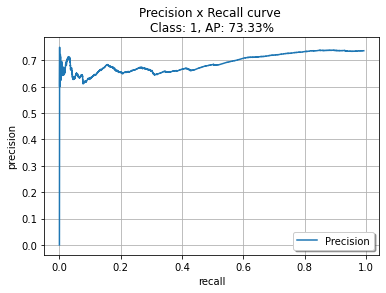

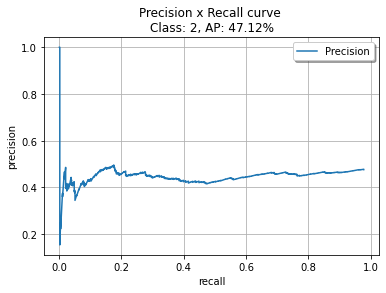

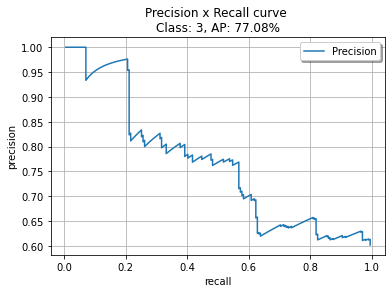

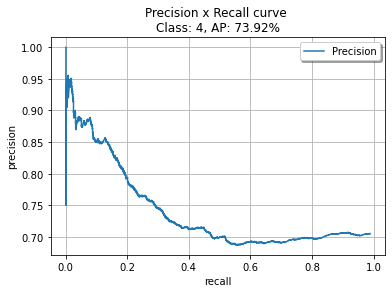

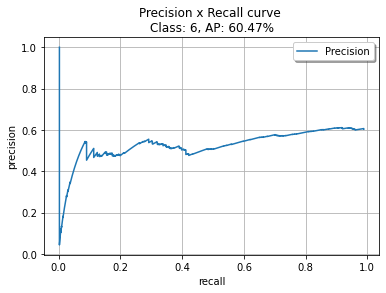

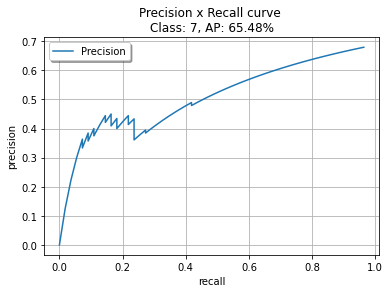

AP: 73.33% (1)
AP: 47.12% (2)
AP: 77.08% (3)
AP: 73.92% (4)
AP: 60.47% (6)
AP: 65.48% (7)
mAP: 66.23%
Total false positive 25


In [10]:
gtfolder = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/groundtruth_txt/'
# detectionfolder = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/detection_txt_confidence/New/'
detectionfolder = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/Final prediction/'
savePath = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/Final Result/'

# Get groundtruth boxes
allBoundingBoxes, allClasses = getBoundingBoxes(gtfolder,True,BBFormat.XYX2Y2,CoordinatesType.Absolute)

# Get detected boxes
allBoundingBoxes, allClasses = getBoundingBoxes(
    detectionfolder, False, BBFormat.XYX2Y2, CoordinatesType.Absolute, allBoundingBoxes, allClasses)
allClasses.sort()

iouThreshold = 0.5
evaluator = Evaluator()
acc_AP = 0
validClasses = 0

# Plot Precision x Recall curve
detections = evaluator.PlotPrecisionRecallCurve(
    allBoundingBoxes,  # Object containing all bounding boxes (ground truths and detections)
    IOUThreshold=iouThreshold,  # IOU threshold
    method=MethodAveragePrecision.EveryPointInterpolation,
    showAP=True,  # Show Average Precision in the title of the plot
    showInterpolatedPrecision=False,  # Don't plot the interpolated precision curve
    savePath=savePath,
    showGraphic=True)

f = open(os.path.join(savePath, 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/Final Result/results.txt'), 'w')
# f = open(savePath,"w+")
f.write('Object Detection Metrics\n')
f.write('Average Precision (AP), Precision and Recall per class:')

# each detection is a class
for metricsPerClass in detections:    
    # Get metric values per each class
    cl = metricsPerClass['class']
    ap = metricsPerClass['AP']
    precision = metricsPerClass['precision']
    recall = metricsPerClass['recall']
    totalPositives = metricsPerClass['total positives']
    total_TP = metricsPerClass['total TP']
    total_FP = metricsPerClass['total FP']

    if totalPositives > 0:
        validClasses = validClasses + 1
        acc_AP = acc_AP + ap
        prec = ['%.2f' % p for p in precision]
        rec = ['%.2f' % r for r in recall]
        ap_str = "{0:.2f}%".format(ap * 100)
        # ap_str = "{0:.4f}%".format(ap * 100)
        print('AP: %s (%s)' % (ap_str, cl))
        f.write('\n\nClass: %s' % cl)
        f.write('\nAP: %s' % ap_str)
        f.write('\nPrecision: %s' % prec)
        f.write('\nRecall: %s' % rec)

mAP = acc_AP / validClasses
mAP_str = "{0:.2f}%".format(mAP * 100)
print('mAP: %s' % mAP_str)
f.write('\n\n\nmAP: %s' % mAP_str)
print('Total false positive %d'%total_FP)

### Another approach
##### 11-point interpolated average precision to calculate mean Average Precision(mAP)

In [1]:
# Just to fill the ground truth boxes and prediction boxes in variables
import os
from os import listdir
import glob
    
gtfolder = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/groundtruth_txt/'
# detectionfolder = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/detection_txt_confidence/New/'
detectionfolder = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/Final prediction/'
gt_boxes = {}
pred_boxes = {}

# Read ground truths
os.chdir(gtfolder)
files = glob.glob("*.txt")
files.sort()

for f in files:
    box_score = {"boxes":[],"category":[]}
    nameOfImage = f.replace(".txt", "")
    fh1 = open(f, "r")
    for line in fh1:
        line = line.replace("\n", "")
        if line.replace(' ', '') == '':
            continue
        splitLine = line.split(",")            

        x = float(splitLine[0])
        y = float(splitLine[1])
        w = float(splitLine[2])
        h = float(splitLine[3])
        catg=float(splitLine[4])
        
#         arr = [x,y,w,h]
        
#         if nameOfImage in gt_boxes:            
#             gt_boxes[nameOfImage].append(arr)
#         else:            
#             gt_boxes[nameOfImage] = [arr]  

        box_score["boxes"].append([x,y,w,h])
        box_score["category"].append(catg)            
                            
    gt_boxes[nameOfImage] = box_score        

# Read detection files
os.chdir(detectionfolder)
files = glob.glob("*.txt")
files.sort()

for f in files:
    box_score={"boxes":[],"scores":[],"category":[]}
    nameOfImage = f.replace(".txt", "")
    fh1 = open(f, "r")        
    for line in fh1:
        line = line.replace("\n", "")
        if line.replace(' ', '') == '':
            continue
        splitLine = line.split(",")            
                
        x = float(splitLine[0])
        y = float(splitLine[1])
        w = float(splitLine[2])
        h = float(splitLine[3])
        catg=float(splitLine[4])
        scr = float(splitLine[5])                                                 
                        
        box_score["boxes"].append([x,y,w,h])
#         box_score["scores"].append(scr)
        box_score["category"].append(catg)                        
    
    pred_boxes[nameOfImage] = box_score


In [29]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

In [30]:
import numpy as np
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [31]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)


In [32]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """    
    gt_catg = gt_boxes['category']
    pred_catg = pred_boxes['category']
    
    gt_boxes_ = gt_boxes['boxes']
    pred_boxes_ = pred_boxes['boxes']
    
    all_pred_indices= range(len(pred_boxes_))
    all_gt_indices=range(len(gt_boxes_))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes_):
        for igb, gt_box in enumerate(gt_boxes_):            
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
#                 if gt_catg[igb] == pred_catg[ipb]:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)

    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes_) - len(pred_match_idx)
        fn = len(gt_boxes_) - len(gt_match_idx)        
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [33]:
from copy import deepcopy
def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())
    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
#         pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_bb)
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        print("Mode score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
        for img_id in img_ids:               
            gt_boxes_img = gt_boxes[img_id]
#             box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]
    # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id], iou_thr)
    # calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            print(recalls,"Recall")
            print(recall_level,"Recall Level")
            print(args, "Args")
            print(prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [ ]:
get_avg_precision_at_iou(gt_boxes,pred_boxes,iou_thr=0.5)

In [41]:
a=get_single_image_results(gt_boxes["xl_visual_session0002_00003110"],pred_boxes["xl_visual_session0002_00003110"],iou_thr=0.8)
print(a['false_positive'])

5


In [4]:
gt_boxes["xl_visual_session0002_00003110"]

{'boxes': [[29.0, 96.0, 281.0, 263.0],
  [333.0, 87.0, 631.0, 303.0],
  [889.0, 67.0, 984.0, 148.0],
  [210.0, 79.0, 302.0, 157.0],
  [626.0, 70.0, 675.0, 101.0],
  [844.0, 52.0, 916.0, 127.0],
  [10.0, 74.0, 63.0, 216.0],
  [329.0, 81.0, 380.0, 137.0],
  [718.0, 75.0, 750.0, 97.0],
  [342.0, 68.0, 457.0, 139.0],
  [1295.0, 27.0, 1349.0, 217.0],
  [781.0, 51.0, 851.0, 117.0]],
 'category': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 1.0, 4.0]}

In [13]:
# Temporary funciton for average score
#  Recall - TP/TP+FN
# Prec - TP/TP+FP
    
recall_scores = []
prec_scores = []
tp=0
fp=0
fn=0
recall = 0
precision =0
count=0
for i in gt_boxes:
    val = get_single_image_results(gt_boxes[i],pred_boxes[i],iou_thr=0.8)
    tp=val['true_positive']
    fp=val['false_positive']
    fn=val['false_negative']
    
    if (tp+fn) != 0:
        recall = tp/(tp+fn)
        recall_scores.append(recall)
    if (tp+fp) !=0:
        precision = tp/(tp+fp)
        prec_scores.append(precision)        
    
    count+=1
    
    
a = np.array(recall_scores)    
b = np.array(prec_scores)
print('Recall %f'%(np.mean(a)))
print('Precision %f'%(np.mean(b)))
            
    

Recall 0.912155
Precision 0.932221


### Distribution of object categories (Validation Data set)

In [15]:
import os
import glob
gtfolder = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/groundtruth_txt/'
# Read ground truths
person = 0
bicycle = 0
motorcycle = 0
car = 0
train = 0
truck = 0
bus = 0

def add(data):
    global person
    global bicycle
    global motorcycle
    global car
    global train
    global truck
    global bus
    if data ==1:
        person+=1
    elif data ==2:
        bicycle+=1
    elif data ==3:
        motorcycle+=1
    elif data ==4:
        car+=1
    elif data ==5:
        train+=1
    elif data ==6:
        truck+=1
    elif data ==7:
        bus+=1    

os.chdir(gtfolder)
files = glob.glob("*.txt")    
for f in files:    
    fh1 = open(f, "r")
    for line in fh1:
        line = line.replace("\n", "")
        if line.replace(' ', '') == '':
            continue
        splitLine = line.split(",")                    
        idClass = int(splitLine[4])  # class
        add(idClass)
        
total = (person+bicycle+motorcycle+car+train+truck+bus)/100

print('**Ground Truth(in %)**')
print('Person - %.2f \nBicycle - %.2f \nMotorcycle - %.2f \nCar - %.2f \nTrain - %.2f \nTruck - %.2f \nBus - %.2f' %
#       (person/total,bicycle/total,motorcycle/total,car/total,train/total,truck/total,bus/total))
      (person,bicycle,motorcycle,car,train,truck,bus))     
print(total)

**Ground Truth(in %)**
Person - 4277.00 
Bicycle - 800.00 
Motorcycle - 199.00 
Car - 5525.00 
Train - 0.00 
Truck - 432.00 
Bus - 55.00
112.88


In [54]:
#Get Train detection dataset
import os
from os import listdir
import glob 

train_path = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/label_FasterRCNN/'
train_boxes = {}

# Read ground truths
os.chdir(train_path)
files = glob.glob("*.txt")
files.sort()

for f in files:
    box_score={"boxes":[],"scores":[],"category":[]}
    nameOfImage = f.replace(".txt", "")
    fh1 = open(f, "r")        
    for line in fh1:
        line = line.replace("\n", "")
        if line.replace(' ', '') == '':
            continue
        splitLine = line.split(",")            
                
        x = float(splitLine[0])
        y = float(splitLine[1])
        w = float(splitLine[2])
        h = float(splitLine[3])
        catg=float(splitLine[4])
        scr = float(splitLine[5])                                                 
                        
        box_score["boxes"].append([x,y,w,h])
        box_score["scores"].append(scr)
        box_score["category"].append(catg)                        
    
    train_boxes[nameOfImage] = box_score

In [44]:
area_diff([646.5887,82.9531,684.0550,112.0373],[642.6957,79.6248,681.8069,111.0082])

10.909625940442345

In [62]:
area_diff([[579.4249,91.0431,645.8249,134.0774],[646.5887,82.9531,684.0550,112.0373]],[[575.3651,82.5481,637.3134,128.0906],[642.6957,79.6248,681.8069,111.0082]])

6.097361832235543

In [193]:
#Make batches of the similar images based on:
# 1. Number of detections
# 2. IOU
# 3. Area difference
# Val- Validation dataset detected
# tr - traininf dataset detected

batches = {}

for i in false_positives:
#     i = false_positives[img]
    val = gt_boxes[i]['boxes']
    class_val = gt_boxes[i]['category']
    for j in train_boxes:        
        tr = train_boxes[j]['boxes']
        class_tr = train_boxes[j]['category']
                        
        #1. Comparing the classes    
        if class_val == class_tr:

        #2. Average IoU
            if avg_iou(val,tr)>0.65:                
        #3. Area difference
#                 if avg_area_diff(val,tr) <= 10:                    
        # Average distance among the objects in image                       
                if average_distance(val,tr) <10:                                        
                    if i in batches:
                        batches[i].append(j)                    
                    else:
                        batches[i] = [j]

                

In [73]:
def avg_area_diff(gt_boxes,pred_boxes,thr=16):
    areas=[]
    value=0
    for ipb, pred_bbox in enumerate(pred_boxes):
        for igb, gt_bbox in enumerate(gt_boxes):                            
            x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
            x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox

            GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
            Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
                    
            if GT_bbox_area>Pred_bbox_area:
                value = abs(GT_bbox_area-Pred_bbox_area)*100/GT_bbox_area
            else:
                value = abs(GT_bbox_area-Pred_bbox_area)*100/Pred_bbox_area
                
            if value<thr:
                areas.append(value)
    return(np.mean(areas))

In [75]:
def avg_iou(gt_boxes,pred_boxes,iou_thr=0.4):
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):        
            iou= calc_iou(gt_box, pred_box)

            if iou >iou_thr:
                ious.append(iou)
    return(np.mean(ious))

In [191]:
# Calculate the distance between objects in an image
from itertools import combinations

def distance_between_objects(box1,box2):
    
    x1, y1, x1b, y1b = box1
    x2, y2, x2b, y2b = box2
    
    left = x2b < x1
    right = x1b < x2
    bottom = y2b < y1
    top = y1b < y2    
    
    #dist is euclidean distance between two points
    if top and left:
        return distance.euclidean((x1, y1b), (x2b, y2))
    elif left and bottom:
        return distance.euclidean((x1, y1), (x2b, y2b))
    elif bottom and right:
        return distance.euclidean((x1b, y1), (x2, y2b))
    elif right and top:
        return distance.euclidean((x1b, y1b), (x2, y2))
    elif left:
        return x1 - x2b
    elif right:
        return x2 - x1b
    elif bottom:
        return y1 - y2b
    elif top:
        return y2 - y1b
    else:             # rectangles intersect
        return 0        

def average_distance(val_boxes,train_boxes):    
    
    distances_val = []
    distances_train = []
    
    #Indices 
    L = [index for index, element in enumerate(val_boxes)]     
    #To get two unique boxes in an image at one time
    for pos in combinations(L,2):
        a,b = pos        
        distances_val.append(distance_between_objects(val_boxes[a],val_boxes[b]))
        distances_train.append(distance_between_objects(train_boxes[a],train_boxes[b]))
        
        if distances_train>distances_val:
            total = np.mean(distances_train)
        else:
            total = np.mean(distances_val)
                
    return((abs(np.mean(distances_val)-np.mean(distances_train))*100)/total)
    

### Make a set of True Positive, False positive and False negative values in a data set

In [3]:
#Make set of 500 TP for each class

def find_tp_fp_fn(gt_boxes, pred_boxes, iou_thr,img):    
    
    box_catg_tp = {"boxes":[],"category":[],"position":[]}
    box_catg_fp = {"boxes":[],"category":[],"position":[]}
    box_catg_fn = {"boxes":[],"category":[],"position":[]}    
    
    gt_catg = gt_boxes['category']
    pred_catg = pred_boxes['category']
    
    gt_boxes_ = gt_boxes['boxes']
    pred_boxes_ = pred_boxes['boxes']
    
    for ipb, pred_box in enumerate(pred_boxes_):
        box_found = False
        for igb, gt_box in enumerate(gt_boxes_):            
            
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                #Atleast one prediction box found in ground truth
                box_found = True               
                if gt_catg[igb] == pred_catg[ipb]:
                    # Right detection and classification - true positive                    
                    box_catg_tp["boxes"].append(gt_box)
                    box_catg_tp["category"].append(gt_catg[igb])
                    box_catg_tp["position"].append(igb)
                else:
                    #Right detection but wrong classification - false positive
                    box_catg_fp["boxes"].append(pred_box)
                    box_catg_fp["category"].append(pred_catg[ipb])
                    box_catg_fp["position"].append(ipb)                

        #Prediction not found in ground truth at all - false positive
        if box_found == False:
            box_catg_fp["boxes"].append(pred_box)
            box_catg_fp["category"].append(pred_catg[ipb])
            box_catg_fp["position"].append(ipb)
            
    #No prediction box in prediciton dataset - false negative
    for pos,val in enumerate(gt_boxes_):
        if (val not in box_catg_tp["boxes"]) and (val not in box_catg_fp["boxes"]):            
            box_catg_fn["boxes"].append(val)
            box_catg_fn["category"].append(gt_catg[pos])
            box_catg_fn["position"].append(pos)

    return(box_catg_tp,box_catg_fp,box_catg_fn)


In [4]:
# Running for all the values 
# Calculate:
#     true_positives
#     false_positives
#     false_negatives

true_positives={}
false_positives={}
false_negatives={}

for i in gt_boxes:
    tp,fp,fn = find_tp_fp_fn(gt_boxes[i],pred_boxes[i],0.5,i)

    true_positives[i] = tp
    false_positives[i] = fp
    false_negatives[i] = fn    
    

In [5]:
# Finding the 3d points for true positive, false positive and false negative
#Reading the files from point cloud text(gt and prediction)

import os
from os import listdir
import glob

gt_cloud = "C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/pointcloud_txt_gt/"

true_positive_3d = {} #ground truth
false_negative_3d = {} #ground truth


#ground truth will cover - tp and fn
os.chdir(gt_cloud)
files = glob.glob("*.txt")
files.sort()
    
for f in files:    
    temp=[]
    name = f.replace(".txt", "")
    tp_pos = true_positives[name]["position"]
    fn_pos = false_negatives[name]["position"] 
    
    fh1 = open(f, "r")    
    
    true_positive_3d[name]=[]
    false_negative_3d[name]=[]
    
    for line in fh1:        
                        
        line = line.replace("\n", "")
        if line.replace(' ', '') == '':
            continue
        splitLine = line.split(",")            

        distance = float(splitLine[0])
        intensity = float(splitLine[1])
        x_min = float(splitLine[2])
        x_max = float(splitLine[3])
        y_min = float(splitLine[4])
        y_max = float(splitLine[5]) 
        z_min = float(splitLine[6])
        z_max = float(splitLine[7])
        non_ground = splitLine[8]
        num = splitLine[9]
        catg = splitLine[10]
        
        temp.append([distance,intensity,x_min,x_max,y_min,y_max,z_min,z_max,non_ground,num,catg])
    
    for i in tp_pos:                        
        true_positive_3d[name].append(temp[i])
    
    for j in fn_pos:        
        false_negative_3d[name].append(temp[j])
        
    fh1.close()    
    

In [6]:
# Run to calculate false_positive_3d
pred_cloud = "C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/pointcloud_txt_detection/"

false_positive_3d = {} #prediciton

#ground truth will cover - tp and fn
os.chdir(pred_cloud)
files = glob.glob("*.txt")
files.sort()
    
for f in files:    
    temp=[]
    name = f.replace(".txt", "")
    fp_pos = false_positives[name]["position"]
    
    if not fp_pos:
        continue

    fh1 = open(f, "r")
    
    false_positive_3d[name] = []
    
    for line in fh1:
        line = line.replace("\n", "")
        if line.replace(' ', '') == '':
            continue
        splitLine = line.split(",")            

        distance = float(splitLine[0])
        intensity = float(splitLine[1])
        x_min = float(splitLine[2])
        x_max = float(splitLine[3])
        y_min = float(splitLine[4])
        y_max = float(splitLine[5]) 
        z_min = float(splitLine[6])
        z_max = float(splitLine[7])
        non_ground = splitLine[8]
        num = splitLine[9]
        catg = splitLine[10]
        
        temp.append([distance,intensity,x_min,x_max,y_min,y_max,z_min,z_max,non_ground,num,catg])
    
    for i in fp_pos:                                
        false_positive_3d[name].append(temp[i])
        
    fh1.close()
    

In [7]:
print(true_positives['xl_visual_session0000_00000026']["position"][-1])
print(false_positives['xl_visual_session0000_00000068']["position"])
# print(false_negatives['xl_visual_session0000_00000026'])

2
[0, 1, 2]


### Separating False positive for each category

In [56]:
# All false positive person, bicycle, motorcycle, car, train, bus, truck

person_3dcloud_fp = [] #1
bicycle_3dcloud_fp = [] #2
motorcycle_3dcloud_fp = [] #3
cars_3dcloud_fp = [] #4
truck_3dcloud_fp = [] #6
bus_3dcloud_fp = [] #7
count_car=0
for i in false_positive_3d:
    for j in false_positive_3d[i]:        
        if j[-1] ==1:
            arr=[j,i]
            count_car+=1
            person_3dcloud_fp.append(arr)
        elif j[-1]==2:
            arr=[j,i]
            bicycle_3dcloud_fp.append(arr)
        elif j[-1]==3:
            arr=[j,i]
            motorcycle_3dcloud_fp.append(arr)
        elif j[-1]==4:
            arr=[j,i]
            cars_3dcloud_fp.append(arr)
        elif j[-1]==6:
            arr=[j,i]
            truck_3dcloud_fp.append(arr)
        elif j[-1]==7:
            arr=[j,i]
            bus_3dcloud_fp.append(arr)
   

In [57]:
count_car

209

In [ ]:
# For "car":
# Frame name     2D bbox              3D distance      2D box area        number of points         3D bbox                              3D height           distance_to_ground*  Label
# xw_session..     (x1,y1,x2,y2)     x meters             x pixels                                x                             (x1,y1,z1,x2,y2,z2)                =z1-z2                                  0m                         True Positive
# xw_session..     (x1,y1,x2,y2)     x meters             x pixels                                x                             (x1,y1,z1,x2,y2,z2)                =z1-z2                                  5m                         False Positve


In [7]:
quad_box =[[1,0,767,256],
       [767,0,1535,256],
       [1,256,767,511],
       [767,256,1535,511]]
    
def get_quadrant(gt_bbox):
    iou_scores=[]
    for i in quad_box:
        iou_scores.append(calc_iou(gt_bbox,i))

    index_max = max(range(len(iou_scores)), key=iou_scores.__getitem__)
    return(index_max+1)
    

In [8]:
# Saving all the car's 

def find_tp_fp(catg):
    obj=[]
    for i in pred_boxes:
        if (i in true_positive_3d.keys()) and (catg in true_positives[i]['category']):
            for pos,val in enumerate(true_positives[i]['category']):
                if val == catg:
                    u1,v1,u2,v2 = true_positives[i]['boxes'][pos]                                     
                    distance_3d = (true_positive_3d[i][pos][0])/1000
                    box_area_2d = (u2 - u1 + 1) * (v2 - v1 + 1)
                    quadrant = get_quadrant([u1,v1,u2,v2])
                    
                    #To skip the non detected point cloud boxes[-1,-1,-1,-1,-1,-1]
                    if distance_3d <0:                        
                        obj.append([i,(u1,v1,u2,v2),0,box_area_2d,0,0,quadrant,0,0,0,'TP'])
                        continue
                                        
                    intensity = true_positive_3d[i][pos][1]
                    non_ground_count = true_positive_3d[i][pos][-3]
                    points_count = true_positive_3d[i][pos][-2]
                    x1,y1,x2,y2,z1,z2 = true_positive_3d[i][pos][2:8]
                    height_3d = z2-z1                                        

                    arr = [i,(u1,v1,u2,v2),distance_3d,box_area_2d,non_ground_count,
                           points_count,quadrant,intensity,(x1,y1,x2,y2,z1,z2),height_3d,'TP']
                    obj.append(arr)

        if (i in false_positive_3d.keys()) and (catg in false_positives[i]['category']):
            for pos,val in enumerate(false_positives[i]['category']):
                if val == catg:                     
                    u1,v1,u2,v2 = false_positives[i]['boxes'][pos]
                    box_area_2d = (u2 - u1 + 1) * (v2 - v1 + 1)
                    distance_3d = (false_positive_3d[i][pos][0])/1000
                    quadrant = get_quadrant([u1,v1,u2,v2])
                    
                    #To skip the non detected point cloud boxes
                    if distance_3d <=0:                        
                        obj.append([i,(u1,v1,u2,v2),0,box_area_2d,0,0,quadrant,0,0,0,'FP'])
                        continue                    
                    
                    intensity = false_positive_3d[i][pos][1]
                    non_ground_count = false_positive_3d[i][pos][-3]
                    points_count = false_positive_3d[i][pos][-2]
                    x1,y1,x2,y2,z1,z2 = false_positive_3d[i][pos][2:8]                    
                    height_3d = z2-z1                    

                    arr = [i,(u1,v1,u2,v2),distance_3d,box_area_2d,non_ground_count,
                           points_count,quadrant,intensity,(x1,y1,x2,y2,z1,z2),height_3d,'FP']
                    obj.append(arr)
    return(obj)    
                

In [ ]:
#  {'person':1,'bicycle':2,'motorcycle':3,'car':4,'train':5,'truck':6,'bus':7}

In [27]:
car = find_tp_fp(4)
pedestrian = find_tp_fp(1)

In [9]:
bicycle = find_tp_fp(2)
motorcycle = find_tp_fp(3)
truck = find_tp_fp(6)
bus = find_tp_fp(7)

In [28]:
# converting list to pandas dataframe
import pandas as pd

df_car = pd.DataFrame(car,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])
df_car.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\val\cars.csv', index = False, header=True)

In [10]:
# converting list to pandas dataframe
import pandas as pd

df_bicycle = pd.DataFrame(bicycle,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])
df_bicycle.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\val\bicycle.csv', index = False, header=True)

df_motorcycle = pd.DataFrame(motorcycle,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])
df_motorcycle.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\val\motorcycle.csv', index = False, header=True)

df_truck = pd.DataFrame(truck,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])
df_bicycle.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\val\truck.csv', index = False, header=True)

df_bus = pd.DataFrame(bus,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])
df_bus.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\val\bus.csv', index = False, header=True)

In [29]:
df_pedestrian= pd.DataFrame(pedestrian,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])
df_pedestrian.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\val\pedestrian.csv', index = False, header=True)

In [24]:
df_pedestrian.head()

,Frame Name,2D bbox,3D distance,2D box area,Non ground points,number of points,Quadrant,Intensity,3D bbox,3D height,Label
0,xl_visual_session0000_00001950,"(907.0, 11.0, 932.0, 60.0)",89.66057,1300.0,11,11,2,4365811.0,"(53789.62, 118844.39, 3936.31, 9151.02, -2014....",1694.29,TP
1,xl_visual_session0000_00001955,"(918.0, 14.0, 941.0, 63.0)",87.13472,1200.0,11,11,2,4521460.0,"(70326.21, 112020.54, 5399.84, 8840.14, -1877....",1671.25,TP
2,xl_visual_session0000_00001973,"(970.0, 15.0, 1000.0, 76.0)",62.83258,1922.0,16,16,2,3781047.0,"(52050.92, 89631.82, 4884.81, 8252.13, -1789.0...",1438.18,TP
3,xl_visual_session0000_00001985,"(1021.0, 35.0, 1060.0, 102.0)",52.79721,2720.0,22,22,2,3675654.5,"(41213.71, 75234.09, 4849.61, 8630.47, -1207.2...",1449.38,TP
4,xl_visual_session0000_00001988,"(1038.0, 33.0, 1078.0, 109.0)",47.69475,3157.0,27,27,2,3435614.0,"(28581.75, 76944.55, 3528.0, 8987.42, -1256.79...",1397.98,TP


In [25]:
df_car.head()

,Frame Name,2D bbox,3D distance,2D box area,Non ground points,number of points,Quadrant,Intensity,3D bbox,3D height,Label
0,xl_visual_session0000_00000026,"(677.0, 99.0, 776.0, 173.0)",66.83051,7500.0,36,39,1,10127321.0,"(15282.41, 161917.77, -2250.72, 2676.59, -891....",3805.38,TP
1,xl_visual_session0000_00000026,"(596.0, 91.0, 645.0, 129.0)",104.66215,1950.0,2,3,1,164345536.0,"(92712.36, 109656.31, -4685.4, -3184.3, 1610.9...",943.48,TP
2,xl_visual_session0000_00000026,"(646.0, 82.0, 684.0, 112.0)",112.88428,1209.0,4,4,1,4725112.0,"(19388.46, 161917.77, -3242.25, -373.99, -1039...",3953.12,TP
3,xl_visual_session0000_00000051,"(686.0, 64.0, 787.0, 143.0)",65.42944,8160.0,42,46,1,6588425.5,"(18893.33, 140377.39, -889.42, 3052.09, -804.8...",2355.96,TP
4,xl_visual_session0000_00000051,"(628.0, 48.0, 671.0, 82.0)",104.73234,1540.0,3,3,1,60468912.0,"(19571.54, 165631.45, -3664.81, -535.76, -1203...",2159.05,TP


In [45]:
import pandas as pd
df_cars = pd.read_csv(r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\val\cars.csv')
df_pedestrian = pd.read_csv(r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\val\pedestrian.csv')

In [21]:
print ("Total number of rows in dataset = {}".format(df_cars.shape[0]))
print ("Total number of columns in dataset = {}".format(df_cars.shape[1]))

Total number of rows in dataset = 5336
Total number of columns in dataset = 9


## To create dataframes for Train dataset

In [11]:
import os
from os import listdir
import glob
import numpy as np

def get_lines_train(folder,is2D):
    os.chdir(folder)
    files = glob.glob("*.txt")
    files.sort()    
    temp = {}

    for f in files:        
        nameOfImage = f.replace(".txt", "")
        temp[nameOfImage] = []
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n", "")
            if line.replace(' ', '') == '':
                continue
            splitLine = line.split(",")            

            if is2D:
                x = float(splitLine[0])
                y = float(splitLine[1])
                w = float(splitLine[2])
                h = float(splitLine[3])
                catg=float(splitLine[4])
                temp[nameOfImage].append([x,y,w,h])
                
            else:
                distance = float(splitLine[0])
                intensity = float(splitLine[1])
                x_min = float(splitLine[2])
                x_max = float(splitLine[3])
                y_min = float(splitLine[4])
                y_max = float(splitLine[5]) 
                z_min = float(splitLine[6])
                z_max = float(splitLine[7])
                non_ground = splitLine[8]
                num = splitLine[9]
                catg = float(splitLine[10])
                temp[nameOfImage].append([distance,intensity,x_min,x_max,y_min,y_max,z_min,z_max,non_ground,num,catg])
    
    return(temp)
            

In [12]:
train_path = "C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/label_FasterRCNN/"
pt_cloud = "C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/pointcloud_txt_detection/"

train_2d = get_lines_train(train_path,True)
train_3d = get_lines_train(pt_cloud,False)

In [13]:
# get traindataset category wise
def get_train(catg):
    obj=[]
    for i in train_3d:
        for pos,val in enumerate(train_3d[i]):
            if val[-1]==catg:
                
                u1,v1,u2,v2 = train_2d[i][pos]
                box_area_2d = (u2 - u1 + 1) * (v2 - v1 + 1)
                distance_3d = val[0]/1000
                quadrant = get_quadrant([u1,v1,u2,v2])
                
                #To skip the non detected point cloud boxes
                if distance_3d <=0:                    
                    obj.append([i,(u1,v1,u2,v2),0,box_area_2d,0,0,quadrant,0,0,0,''])
                    continue                
                
                if np.isnan(val[1]):
                    intensity=0
                else:
                    intensity = val[1]
                x1,y1,x2,y2,z1,z2 = val[2:8]
                non_ground_count = val[-3]
                points_count = val[-2]
                height_3d = z2-z1                
                obj.append([i,(u1,v1,u2,v2),distance_3d,box_area_2d,non_ground_count,
                            points_count,quadrant,intensity,(x1,y1,x2,y2,z1,z2),height_3d,''])
    return(obj)
    


In [33]:
cars_train = get_train(4)
pedestrian_train = get_train(1)

In [14]:
bicycle_train = get_train(2)
motorcycle_train = get_train(3)
truck_train = get_train(6)
bus_train = get_train(7)

In [34]:
# converting list to pandas dataframe
import pandas as pd

df_cars_train = pd.DataFrame(cars_train,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])
df_pedestrian_train= pd.DataFrame(pedestrian_train,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])

In [16]:
# converting list to pandas dataframe
import pandas as pd

df_bicycle_train = pd.DataFrame(bicycle_train,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])
df_motorcycle_train= pd.DataFrame(motorcycle_train,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])
df_truck_train = pd.DataFrame(truck_train,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])
df_bus_train= pd.DataFrame(bus_train,columns=['Frame Name','2D bbox','3D distance','2D box area','Non ground points','number of points','Quadrant','Intensity','3D bbox', '3D height','Label'])


In [17]:
df_bicycle_train.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\train\bicycle.csv', index = False, header=True)
df_motorcycle_train.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\train\motorcycle.csv', index = False, header=True)
df_truck_train.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\train\truck.csv', index = False, header=True)
df_bus_train.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\train\bus.csv', index = False, header=True)

In [35]:
df_cars_train.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\train\cars.csv', index = False, header=True)
df_pedestrian_train.to_csv (r'C:\Users\nisha\MACS\Internship\Data\XL_CarPedDataset_INT_v2_train_val\train\pedestrian.csv', index = False, header=True)

## Removing the FP and merging cars and pedestrian in an .xlsx

In [18]:
import pandas as pd
df_final_train = pd.read_csv(r'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/final train dataset for annotation.csv')
list_frame = df_final_train.values.tolist()

In [19]:
dict_train={}
for val in list_frame:    
    if val[0] in dict_train:
        dict_train[val[0]].append(val[1:6])
    else:
        dict_train[val[0]] = [val[1:6]]

In [20]:
path = "C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/train/Labels after FP removal/"


for i in dict_train:
    labels_path=path+i+'.txt'
    f= open(labels_path,"w+")
    for val in dict_train[i]:        
        if not np.isnan(val[4]):
            f.write("%.4f,%.4f,%.4f,%.4f,%d\r" % (val[0],val[1],val[2],val[3],val[4]))

    f.close()     


## Compare the model prediction for each class

# 16 bit Raw prediction

In [ ]:
import os
# os.chdir('C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2/')
os.chdir('C:/Users/nisha/MACS/Internship/Data/16 bit Raw/Faster_RCNN_XL_Raw_Visual/')
import torch
import torchvision
from torchvision import transforms
from torchvision.ops import boxes as box_ops
import matplotlib.pyplot as plt
import glob as glob
import cv2
import numpy as np
import onnxruntime
import XenoWareFormat as xw
import time

from model import get_faster_rcnn_model
from drawing_tools import plot_one_box, color_list

def read_matrix(file_name, nr_rows, nr_cols):
    return np.fromfile(file_name, dtype='<d').reshape((nr_rows,nr_cols))  # little-endian double precision float

def normalize_image(image):
    intensity_max = 65535.0 # 2^16
    out = image
    out[np.isnan(out)] = 0.0
    out[out < 0.0]     = 0.0
    out[out > intensity_max] = intensity_max
    out = out/intensity_max
    return out

def scale_image(image):
    ceil  = np.percentile(image,99) # 5% of pixels will be white
    floor = np.percentile(image,1)  # 5% of pixels will be black

    return scale_image_base(image, ceil, floor)

def scale_image_base(image, ceil, floor):

    a = 255/(ceil-floor)
    b = floor*255/(floor-ceil)
    out = np.maximum(0,np.minimum(255,image*a+b)).astype(np.uint8)

    return out

pred_boxes = {}

if __name__ == '__main__':

    category_list = ['__background__','person','bicycle','motorcycle','car','train','truck','bus']
    confidence_threshold = 0.7

    # input image path
    #visual_image_dir = 'E:/data/XenomatiX/test/VisualImages'
    visual_image_dir = 'C:/Users/nisha/MACS/Internship/Data/16 bit Raw/RawVisualImages'

    # .bin format or .xim format
    is_bin = False

    # image size
    nr_rows = 512
    nr_cols = 1536

    num_classes = len(category_list)

    # get the model using our helper function
    model = get_faster_rcnn_model(num_classes)

    # model.load_state_dict(torch.load("weights/faster_rcnn_resnet101_fpn_OPT_SGD_LR_0.005_BS_4_NC_8_InputSize_512_20200827_135820_epoch020.pt"))


    # use CUDA if it is available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model.load_state_dict(torch.load("faster_rcnn_resnet101_fpn_OPT_SGD_LR_0.005_BS_4_NC_8_InputSize_512_20200827_135820_epoch020.pt"))

    # move model to the right device
    model.to(device)

    # put the model in evaluation mode
    model.eval()

    visual_image_filenames = glob.glob(os.path.join(visual_image_dir,'xl_visual*'))

    nr_frames = len(visual_image_filenames)

#     print('Found {} visual images'.format(nr_frames))

    # check file format
    if nr_frames > 0:
        extension = visual_image_filenames[0][-3:]
        if extension == 'bin':
            is_bin = True
    
    
    for i in range (len(visual_image_filenames)):
        visual_image_filename = visual_image_filenames[i]
        name = visual_image_filename[63:93]
        box_score = {"boxes":[],"category":[]}

        if is_bin:
            visual_image = read_matrix(visual_image_filename, nr_rows=nr_rows, nr_cols=nr_cols)
        else:
            (c,_) = xw.XW_ReadFile(visual_image_filename)
            visual_image = c['data']

        visual_image_norm = normalize_image(visual_image)
        input_tensor = torch.from_numpy(visual_image_norm).float().to(device)
        input_tensor = input_tensor.unsqueeze(0)

#         print(input_tensor.shape)

        visual_image_scaled = scale_image(visual_image)

        with torch.no_grad():
            prediction = model([input_tensor])            

#         for i in range(len(prediction[0]['boxes'])):
#             print(prediction[0]['boxes'][i])
#             print(prediction[0]['labels'][i])
                      
            boxes = (prediction[0]['boxes']).tolist()
            catg = (prediction[0]['labels']).tolist()
#             print(prediction[0]['boxes'])
            box_score["boxes"] = boxes
            box_score["category"] = catg
        
            pred_boxes[name] = box_score


In [9]:
import os
import glob
import XenoWareFormat as xw


os.chdir('C:/Users/nisha/MACS/Internship/Data/16 bit Raw/Faster_RCNN_XL_Raw_Visual/')
visual_image_dir = 'C:/Users/nisha/MACS/Internship/Data/16 bit Raw/RawVisualImages'

visual_image_filename = glob.glob(os.path.join(visual_image_dir,'xl_visual_session0003_00003383.vis'))

(c,_) = xw.XW_ReadFile(visual_image_filename[0])

visual_image = c['data']



<ipython-input-15-c64007bdf5d5>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('C:/Users/nisha/MACS/Internship/Data/16bit.png', dpi=200, frameon=False, padinches=0)
<ipython-input-15-c64007bdf5d5>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padinches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('C:/Users/nisha/MACS/Internship/Data/16bit.png', dpi=200, frameon=False, padinches=0)


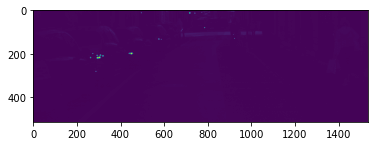

In [15]:
import matplotlib.pyplot as plt
plt.imshow(visual_image) 

plt.savefig('C:/Users/nisha/MACS/Internship/Data/16bit.png', dpi=200, frameon=False, padinches=0)

In [22]:
# Just to fill the ground truth boxes and prediction boxes in variables
import os
from os import listdir
import glob
    
gtfolder = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/groundtruth_txt/'
# detectionfolder = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/detection_txt_confidence/New/'
gt_boxes = {}
# pred_boxes = {}

# Read ground truths
os.chdir(gtfolder)
files = glob.glob("*.txt")
files.sort()

for f in files:
    box_score = {"boxes":[],"category":[]}
    nameOfImage = f.replace(".txt", "")
    fh1 = open(f, "r")
    for line in fh1:
        line = line.replace("\n", "")
        if line.replace(' ', '') == '':
            continue
        splitLine = line.split(",")            

        x = float(splitLine[0])
        y = float(splitLine[1])
        w = float(splitLine[2])
        h = float(splitLine[3])
        catg=float(splitLine[4])
        
        arr = [x,y,w,h]        

        box_score["boxes"].append([x,y,w,h])
        box_score["category"].append(catg)            
                            
    gt_boxes[nameOfImage] = box_score        


In [58]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """    
    gt_catg = gt_boxes['category']
    pred_catg = pred_boxes['category']
    
    gt_boxes_ = gt_boxes['boxes']
    pred_boxes_ = pred_boxes['boxes']
    
    all_pred_indices = range(len(pred_boxes_))
    all_gt_indices = range(len(gt_boxes_))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes_):
        for igb, gt_box in enumerate(gt_boxes_):            
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                if gt_catg[igb] == pred_catg[ipb]:
                    gt_idx_thr.append(igb)
                    pred_idx_thr.append(ipb)
                    ious.append(iou)

    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes_) - len(pred_match_idx)
        fn = len(gt_boxes_) - len(gt_match_idx)        
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

## Getting TP/FP

In [61]:
score_fp=[]
score_tp=[]
score_fn=[]

for i in gt_boxes:
    result = get_single_image_results(gt_boxes[i],pred_boxes[i],iou_thr=0.8)    
    print(i,result)
    score_fp.append(result['false_positive'])
    score_tp.append(result['true_positive'])
    score_fn.append(result['false_negative'])
    
total_score_fp = np.sum(score_fp)
total_score_tp = np.sum(score_tp)
total_score_fn = np.sum(score_fn)

print(total_score_fp,total_score_tp,total_score_fn)

xl_visual_session0000_00000026 {'true_positive': 3, 'false_positive': 1, 'false_negative': 0}
xl_visual_session0000_00000051 {'true_positive': 4, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0000_00000064 {'true_positive': 2, 'false_positive': 2, 'false_negative': 2}
xl_visual_session0000_00000068 {'true_positive': 3, 'false_positive': 1, 'false_negative': 1}
xl_visual_session0000_00000080 {'true_positive': 3, 'false_positive': 2, 'false_negative': 1}
xl_visual_session0000_00000088 {'true_positive': 3, 'false_positive': 1, 'false_negative': 1}
xl_visual_session0000_00000100 {'true_positive': 3, 'false_positive': 1, 'false_negative': 1}
xl_visual_session0000_00000104 {'true_positive': 4, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0000_00000108 {'true_positive': 3, 'false_positive': 1, 'false_negative': 1}
xl_visual_session0000_00000120 {'true_positive': 3, 'false_positive': 1, 'false_negative': 1}
xl_visual_session0000_00000144 {'true_positive': 4, 'false_p

xl_visual_session0002_00000930 {'true_positive': 14, 'false_positive': 14, 'false_negative': 5}
xl_visual_session0002_00000934 {'true_positive': 14, 'false_positive': 15, 'false_negative': 6}
xl_visual_session0002_00000948 {'true_positive': 20, 'false_positive': 9, 'false_negative': 0}
xl_visual_session0002_00000952 {'true_positive': 14, 'false_positive': 17, 'false_negative': 3}
xl_visual_session0002_00000966 {'true_positive': 18, 'false_positive': 9, 'false_negative': 0}
xl_visual_session0002_00000988 {'true_positive': 11, 'false_positive': 12, 'false_negative': 2}
xl_visual_session0002_00001011 {'true_positive': 14, 'false_positive': 9, 'false_negative': 0}
xl_visual_session0002_00001020 {'true_positive': 12, 'false_positive': 10, 'false_negative': 2}
xl_visual_session0002_00001033 {'true_positive': 13, 'false_positive': 16, 'false_negative': 2}
xl_visual_session0002_00001096 {'true_positive': 14, 'false_positive': 7, 'false_negative': 0}
xl_visual_session0002_00001101 {'true_positi

xl_visual_session0002_00003060 {'true_positive': 14, 'false_positive': 4, 'false_negative': 1}
xl_visual_session0002_00003065 {'true_positive': 13, 'false_positive': 5, 'false_negative': 1}
xl_visual_session0002_00003069 {'true_positive': 15, 'false_positive': 9, 'false_negative': 0}
xl_visual_session0002_00003078 {'true_positive': 9, 'false_positive': 9, 'false_negative': 4}
xl_visual_session0002_00003087 {'true_positive': 10, 'false_positive': 7, 'false_negative': 0}
xl_visual_session0002_00003105 {'true_positive': 10, 'false_positive': 7, 'false_negative': 0}
xl_visual_session0002_00003110 {'true_positive': 11, 'false_positive': 5, 'false_negative': 1}
xl_visual_session0002_00003137 {'true_positive': 13, 'false_positive': 7, 'false_negative': 1}
xl_visual_session0002_00003164 {'true_positive': 11, 'false_positive': 12, 'false_negative': 4}
xl_visual_session0002_00003191 {'true_positive': 12, 'false_positive': 10, 'false_negative': 1}
xl_visual_session0002_00003195 {'true_positive': 

xl_visual_session0003_00002147 {'true_positive': 11, 'false_positive': 26, 'false_negative': 5}
xl_visual_session0003_00002174 {'true_positive': 11, 'false_positive': 35, 'false_negative': 7}
xl_visual_session0003_00002204 {'true_positive': 15, 'false_positive': 18, 'false_negative': 4}
xl_visual_session0003_00002216 {'true_positive': 11, 'false_positive': 29, 'false_negative': 6}
xl_visual_session0003_00002221 {'true_positive': 8, 'false_positive': 34, 'false_negative': 9}
xl_visual_session0003_00002227 {'true_positive': 10, 'false_positive': 22, 'false_negative': 5}
xl_visual_session0003_00002245 {'true_positive': 11, 'false_positive': 27, 'false_negative': 7}
xl_visual_session0003_00002261 {'true_positive': 5, 'false_positive': 10, 'false_negative': 1}
xl_visual_session0003_00002270 {'true_positive': 5, 'false_positive': 21, 'false_negative': 5}
xl_visual_session0003_00002308 {'true_positive': 7, 'false_positive': 10, 'false_negative': 2}
xl_visual_session0003_00002315 {'true_positi

xl_visual_session0003_00004387 {'true_positive': 11, 'false_positive': 11, 'false_negative': 3}
xl_visual_session0003_00004427 {'true_positive': 10, 'false_positive': 14, 'false_negative': 2}
xl_visual_session0003_00004498 {'true_positive': 10, 'false_positive': 3, 'false_negative': 1}
xl_visual_session0003_00004507 {'true_positive': 11, 'false_positive': 6, 'false_negative': 1}
xl_visual_session0003_00004542 {'true_positive': 9, 'false_positive': 11, 'false_negative': 1}
xl_visual_session0003_00004562 {'true_positive': 9, 'false_positive': 9, 'false_negative': 3}
xl_visual_session0003_00004599 {'true_positive': 9, 'false_positive': 4, 'false_negative': 2}
xl_visual_session0003_00004631 {'true_positive': 9, 'false_positive': 13, 'false_negative': 2}
xl_visual_session0003_00004640 {'true_positive': 12, 'false_positive': 10, 'false_negative': 0}
xl_visual_session0003_00004655 {'true_positive': 9, 'false_positive': 8, 'false_negative': 1}
xl_visual_session0003_00004669 {'true_positive': 1

xl_visual_session0004_00003348 {'true_positive': 2, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0004_00003350 {'true_positive': 2, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0004_00003351 {'true_positive': 2, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0004_00003358 {'true_positive': 2, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0004_00003373 {'true_positive': 2, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0004_00003376 {'true_positive': 2, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0004_00003379 {'true_positive': 2, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0005_00000131 {'true_positive': 7, 'false_positive': 4, 'false_negative': 0}
xl_visual_session0005_00000133 {'true_positive': 7, 'false_positive': 6, 'false_negative': 0}
xl_visual_session0005_00000148 {'true_positive': 7, 'false_positive': 1, 'false_negative': 0}
xl_visual_session0005_00000150 {'true_positive': 6, 'false_p

xl_visual_session0005_00004126 {'true_positive': 7, 'false_positive': 4, 'false_negative': 0}
xl_visual_session0005_00004134 {'true_positive': 6, 'false_positive': 5, 'false_negative': 0}
xl_visual_session0005_00004136 {'true_positive': 5, 'false_positive': 5, 'false_negative': 1}
xl_visual_session0005_00004138 {'true_positive': 5, 'false_positive': 5, 'false_negative': 0}
xl_visual_session0005_00004149 {'true_positive': 4, 'false_positive': 4, 'false_negative': 0}
xl_visual_session0005_00004151 {'true_positive': 6, 'false_positive': 2, 'false_negative': 0}
xl_visual_session0005_00004163 {'true_positive': 8, 'false_positive': 3, 'false_negative': 0}
xl_visual_session0005_00004184 {'true_positive': 6, 'false_positive': 6, 'false_negative': 0}
xl_visual_session0005_00004186 {'true_positive': 7, 'false_positive': 5, 'false_negative': 0}
xl_visual_session0005_00004199 {'true_positive': 8, 'false_positive': 8, 'false_negative': 0}
xl_visual_session0005_00004201 {'true_positive': 8, 'false_p

xl_visual_session0005_00009122 {'true_positive': 10, 'false_positive': 3, 'false_negative': 0}
xl_visual_session0005_00009126 {'true_positive': 10, 'false_positive': 2, 'false_negative': 0}
xl_visual_session0005_00009132 {'true_positive': 7, 'false_positive': 4, 'false_negative': 1}
xl_visual_session0005_00009138 {'true_positive': 10, 'false_positive': 1, 'false_negative': 0}
xl_visual_session0005_00009144 {'true_positive': 12, 'false_positive': 3, 'false_negative': 0}
xl_visual_session0005_00009146 {'true_positive': 11, 'false_positive': 2, 'false_negative': 0}
xl_visual_session0005_00009151 {'true_positive': 10, 'false_positive': 4, 'false_negative': 1}
xl_visual_session0005_00009165 {'true_positive': 13, 'false_positive': 4, 'false_negative': 0}
xl_visual_session0005_00009175 {'true_positive': 11, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0005_00009184 {'true_positive': 12, 'false_positive': 0, 'false_negative': 0}
xl_visual_session0005_00009192 {'true_positive': 10

In [40]:
path = "C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/Final prediction/"
for i in pred_boxes:    
    labels_path = path+i+'.txt'
    f = open(labels_path,"w+")
    for pos,val in enumerate(pred_boxes[i]['boxes']):
        f.write("%.2f,%.2f,%.2f,%.2f,%d\r"%(val[0],val[1],val[2],val[3],pred_boxes[i]['category'][pos]))
    f.close()
    

In [54]:
pred_boxes['xl_visual_session0002_00000387']

{'boxes': [[684.5831909179688,
   65.04529571533203,
   822.5634765625,
   187.24476623535156],
  [605.711181640625, 65.82211303710938, 675.2811279296875, 125.75077819824219],
  [1243.05126953125, 72.28565979003906, 1304.94482421875, 205.37362670898438],
  [349.32672119140625,
   64.59368133544922,
   457.11444091796875,
   148.4347686767578],
  [1081.0784912109375,
   67.74000549316406,
   1264.4202880859375,
   145.73043823242188],
  [885.7490844726562, 63.52130889892578, 939.023681640625, 106.81635284423828],
  [935.269287109375,
   66.01365661621094,
   1001.1487426757812,
   121.62299346923828],
  [505.58984375, 64.0499267578125, 569.570068359375, 117.13196563720703],
  [666.448974609375, 67.66883850097656, 709.5735473632812, 108.84821319580078],
  [1250.51513671875, 139.509765625, 1304.4698486328125, 220.68055725097656],
  [801.649658203125, 47.52809143066406, 824.4478149414062, 66.72103118896484],
  [771.5206298828125,
   51.849952697753906,
   798.0000610351562,
   70.498329162

In [52]:
gt_boxes['xl_visual_session0002_00000387']

{'boxes': [[684.0, 64.0, 820.0, 189.0],
  [350.0, 66.0, 458.0, 149.0],
  [1239.0, 76.0, 1304.0, 199.0],
  [1079.0, 69.0, 1266.0, 143.0],
  [606.0, 66.0, 676.0, 126.0],
  [887.0, 65.0, 938.0, 107.0],
  [506.0, 65.0, 568.0, 116.0],
  [1248.0, 136.0, 1304.0, 221.0],
  [936.0, 66.0, 1000.0, 122.0],
  [800.0, 49.0, 825.0, 69.0],
  [771.0, 55.0, 797.0, 74.0],
  [668.0, 68.0, 707.0, 111.0]],
 'category': [4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0]}

In [59]:
get_single_image_results(gt_boxes['xl_visual_session0002_00000387'],pred_boxes['xl_visual_session0002_00000387'],iou_thr=0.8)

{'true_positive': 10, 'false_positive': 9, 'false_negative': 2}

In [62]:
count =0
for i in gt_boxes:
    count+=len(gt_boxes[i]['boxes'])

print(count)

11288


In [5]:
import os
from os import listdir
import glob
    
gtfolder = 'C:/Users/nisha/MACS/Internship/Data/XL_CarPedDataset_INT_v2_train_val/val/Final prediction/'

# Read ground truths
os.chdir(gtfolder)
files = glob.glob("*.txt")
files.sort()

for f in files:        
    fh1 = open(f, "r")    
    lineCount=0
    for line in fh1:
        lineCount+=1
    print(f,lineCount)
        

xl_visual_session0000_00000026.txt 4
xl_visual_session0000_00000051.txt 4
xl_visual_session0000_00000064.txt 4
xl_visual_session0000_00000068.txt 4
xl_visual_session0000_00000080.txt 5
xl_visual_session0000_00000088.txt 4
xl_visual_session0000_00000100.txt 4
xl_visual_session0000_00000104.txt 4
xl_visual_session0000_00000108.txt 4
xl_visual_session0000_00000120.txt 4
xl_visual_session0000_00000144.txt 5
xl_visual_session0000_00000152.txt 4
xl_visual_session0000_00000160.txt 3
xl_visual_session0000_00000180.txt 3
xl_visual_session0000_00000261.txt 4
xl_visual_session0000_00000321.txt 5
xl_visual_session0000_00000326.txt 5
xl_visual_session0000_00000335.txt 4
xl_visual_session0000_00000353.txt 5
xl_visual_session0000_00000357.txt 4
xl_visual_session0000_00000403.txt 4
xl_visual_session0000_00000408.txt 4
xl_visual_session0000_00000410.txt 4
xl_visual_session0000_00000437.txt 4
xl_visual_session0000_00000461.txt 4
xl_visual_session0000_00000499.txt 4
xl_visual_session0000_00000507.txt 4
x

xl_visual_session0002_00000517.txt 20
xl_visual_session0002_00000535.txt 18
xl_visual_session0002_00000558.txt 19
xl_visual_session0002_00000582.txt 20
xl_visual_session0002_00000604.txt 20
xl_visual_session0002_00000627.txt 20
xl_visual_session0002_00000662.txt 19
xl_visual_session0002_00000680.txt 22
xl_visual_session0002_00000702.txt 22
xl_visual_session0002_00000708.txt 21
xl_visual_session0002_00000720.txt 30
xl_visual_session0002_00000731.txt 25
xl_visual_session0002_00000737.txt 21
xl_visual_session0002_00000773.txt 24
xl_visual_session0002_00000782.txt 26
xl_visual_session0002_00000814.txt 23
xl_visual_session0002_00000864.txt 37
xl_visual_session0002_00000874.txt 26
xl_visual_session0002_00000893.txt 26
xl_visual_session0002_00000897.txt 26
xl_visual_session0002_00000920.txt 27
xl_visual_session0002_00000930.txt 28
xl_visual_session0002_00000934.txt 29
xl_visual_session0002_00000948.txt 29
xl_visual_session0002_00000952.txt 31
xl_visual_session0002_00000966.txt 27
xl_visual_se

xl_visual_session0003_00001213.txt 16
xl_visual_session0003_00001249.txt 13
xl_visual_session0003_00001258.txt 17
xl_visual_session0003_00001262.txt 14
xl_visual_session0003_00001330.txt 15
xl_visual_session0003_00001348.txt 12
xl_visual_session0003_00001358.txt 13
xl_visual_session0003_00001361.txt 13
xl_visual_session0003_00001371.txt 12
xl_visual_session0003_00001413.txt 16
xl_visual_session0003_00001436.txt 15
xl_visual_session0003_00001439.txt 17
xl_visual_session0003_00001449.txt 23
xl_visual_session0003_00001452.txt 12
xl_visual_session0003_00001458.txt 15
xl_visual_session0003_00001467.txt 11
xl_visual_session0003_00001472.txt 16
xl_visual_session0003_00001489.txt 11
xl_visual_session0003_00001491.txt 11
xl_visual_session0003_00001496.txt 13
xl_visual_session0003_00001498.txt 9
xl_visual_session0003_00001517.txt 10
xl_visual_session0003_00001533.txt 9
xl_visual_session0003_00001535.txt 8
xl_visual_session0003_00001552.txt 12
xl_visual_session0003_00001558.txt 12
xl_visual_sessi

xl_visual_session0005_00000766.txt 12
xl_visual_session0005_00000774.txt 13
xl_visual_session0005_00000780.txt 14
xl_visual_session0005_00000800.txt 11
xl_visual_session0005_00000820.txt 10
xl_visual_session0005_00000824.txt 10
xl_visual_session0005_00000838.txt 13
xl_visual_session0005_00000845.txt 10
xl_visual_session0005_00000857.txt 9
xl_visual_session0005_00000863.txt 7
xl_visual_session0005_00000869.txt 8
xl_visual_session0005_00000884.txt 9
xl_visual_session0005_00000886.txt 7
xl_visual_session0005_00000888.txt 9
xl_visual_session0005_00000894.txt 10
xl_visual_session0005_00000900.txt 10
xl_visual_session0005_00000904.txt 9
xl_visual_session0005_00000920.txt 8
xl_visual_session0005_00000928.txt 7
xl_visual_session0005_00000934.txt 10
xl_visual_session0005_00000957.txt 6
xl_visual_session0005_00000965.txt 6
xl_visual_session0005_00000969.txt 6
xl_visual_session0005_00000977.txt 6
xl_visual_session0005_00001013.txt 9
xl_visual_session0005_00001029.txt 5
xl_visual_session0005_00001

xl_visual_session0005_00005971.txt 10
xl_visual_session0005_00005981.txt 6
xl_visual_session0005_00005988.txt 6
xl_visual_session0005_00005992.txt 5
xl_visual_session0005_00005996.txt 4
xl_visual_session0005_00006000.txt 4
xl_visual_session0005_00006139.txt 6
xl_visual_session0005_00006141.txt 6
xl_visual_session0005_00006149.txt 6
xl_visual_session0005_00006166.txt 7
xl_visual_session0005_00006182.txt 9
xl_visual_session0005_00006184.txt 9
xl_visual_session0005_00006190.txt 13
xl_visual_session0005_00006206.txt 11
xl_visual_session0005_00006226.txt 7
xl_visual_session0005_00006240.txt 9
xl_visual_session0005_00006250.txt 8
xl_visual_session0005_00006263.txt 6
xl_visual_session0005_00006267.txt 5
xl_visual_session0005_00006279.txt 4
xl_visual_session0005_00006289.txt 8
xl_visual_session0005_00006305.txt 6
xl_visual_session0005_00006307.txt 6
xl_visual_session0005_00006376.txt 5
xl_visual_session0005_00006393.txt 4
xl_visual_session0005_00006397.txt 4
xl_visual_session0005_00006405.txt 

xl_visual_session0005_00011586.txt 12
xl_visual_session0005_00011609.txt 18
xl_visual_session0005_00011625.txt 19
xl_visual_session0005_00011636.txt 18
xl_visual_session0005_00011638.txt 15
xl_visual_session0005_00011640.txt 16
xl_visual_session0005_00011647.txt 15
xl_visual_session0005_00011651.txt 13
xl_visual_session0005_00011655.txt 14
xl_visual_session0005_00011662.txt 14
xl_visual_session0005_00011674.txt 12
xl_visual_session0005_00011677.txt 11
xl_visual_session0005_00011679.txt 11
xl_visual_session0005_00011688.txt 9
xl_visual_session0005_00011692.txt 10
xl_visual_session0005_00011697.txt 11
xl_visual_session0005_00012956.txt 15
xl_visual_session0005_00012975.txt 16
xl_visual_session0005_00012983.txt 16
xl_visual_session0005_00013007.txt 17
xl_visual_session0005_00013017.txt 12
xl_visual_session0005_00013034.txt 12
xl_visual_session0005_00013049.txt 13
xl_visual_session0005_00013062.txt 20
xl_visual_session0005_00013075.txt 15
xl_visual_session0005_00013084.txt 14
xl_visual_ses